# Introduzione
Il problema di ***Authorship Attribution*** è un processo di identificazione di un autore a partire da un testo, e dal punto di vista del Machine Learning è considerato un problema di *classificazione multiclasse*.

Il dataset è ottenuto dall'estrazione di novelle di 45 autori dell' *Era Vittoriana* e ognuna di queste è costituita da 1000 termini.
Siamo partiti dalle attività di preprocessing testuali per "*pulire*" i testi, seguite dall'analisi del training set per osservarne le carattestiche. Data la dimensione elevata del training set, abbiamo applicato tecniche di feature extraction e feature selection per ridurne la dimensionalità, ottendo 3 diversi training sets. 

Per cercare il modello che sia il più affidabile per identificare gli autori, abbiamo usato diversi modelli di classificazione applicati a tutti e 3 i train sets e ne abbiamo confrontato le performances.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np

#Graphics
import seaborn as sns
import matplotlib.pyplot as plt

#Preprocessing 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk import SnowballStemmer

#ML
import sklearn
from sklearn import metrics as mt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier 


#Utils
import os
import string
from collections import Counter
import joblib
import pickle
from itertools import compress


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maryannrodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maryannrodriguez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## ***Funzioni utils***

In [419]:
def RandomizedSearch_table_plot(grid_clf, param_list=[],
                          num_results=40,
                          negative=True,
                          graph=True,
                          display_all_params=True):

  
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    #if display_all_params:
     #   import pprint
      #  pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
    import uuid
      
    scores_df.to_pickle(str(uuid.uuid4())+"file.pkl")
    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    #best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    table=pd.DataFrame(cv_results)
    del table['split0_test_score']
    del table['split1_test_score']
    del table['split2_test_score']
    del table['split3_test_score']
    del table['split4_test_score']
    del table['split0_train_score']
    del table['split1_train_score']
    del table['split2_train_score']
    del table['split3_train_score']
    del table['split4_train_score']
    del table['mean_fit_time']
    del table['std_fit_time']
    del table['mean_score_time']	
    del table['std_score_time']
    del table['params']
    display(table \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='rank_test_score')
    #print(scores_df.keys())
    for param_name in param_list:
        scores_df = scores_df.sort_values(by='param_' + param_name)
        best_param = best_row['param_' + param_name]
        
        if negative:
            means = -scores_df['mean_test_score']
        else:
            means = scores_df['mean_test_score']
        stds = scores_df['std_test_score']
        params = scores_df['param_' + param_name]
        params.fillna(1400, inplace=True)
        #params = [str(i) for i in params]
        # plot
        if graph:
            plt.figure(figsize=(4, 4))
            plt.plot(params, means,"o")

            plt.axhline(y=best_mean + best_stdev, color='red')
            plt.axhline(y=best_mean - best_stdev, color='red')
            plt.plot(best_param, best_mean, 'or')

            plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
            plt.xlabel(param_name)
            plt.ylabel('Score')
    plt.show()
  
#Selezione miglior numero di componenti per TruncatedSVD
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0

    n_components = 0
    
    for explained_variance in var_ratio:
    
        total_variance += explained_variance
        
        n_components += 1
        
        if total_variance >= goal_var:
            break
            
    return n_components


def show_results(labels, predictions):
    print( "Accuracy: ", accuracy_score(labels, predictions))
    print("Avg Precision", precision_score(labels, predictions, average='weighted')) 
    print("Avg Recall",recall_score(labels, predictions, average='weighted')) 
    print("Avg F1-score",f1_score(labels, predictions, average='weighted')) 


#Funzione che visualizza istogramma tra modelli in base a accuracy
def plot_glob_accuracy(model_names,list_accuracy):
    if(len(model_names) == 2):
        y_pos = np.arange(1,3)
        colors = ("teal","mediumturquoise")
        plt.figure(figsize=(8,5))
        plt.xticks(y_pos,model_names,fontsize=14)
        plt.yticks(np.arange(0.00, 1.01, step=0.1))
        plt.ylim(0,1)
        plt.ylabel('Accuracy')
        plt.bar(y_pos,list_accuracy,color=colors)
        plt.grid()
        plt.show()
    else:
        y_pos = np.arange(1,4)
        colors = ("teal","mediumturquoise","mediumaquamarine")
        plt.figure(figsize=(15,5))
        plt.xticks(y_pos,model_names,fontsize=14)
        plt.yticks(np.arange(0.00, 1.01, step=0.1))
        plt.ylim(0,1)
        plt.ylabel('Accuracy')
        plt.bar(y_pos,list_accuracy,color=colors)
        plt.grid()
        plt.show()

             
#...e in base recall
def plot_glob_f1score(model_names,list_f1score):
    if(len(model_names) == 2):
        y_pos = np.arange(1,3)
        colors = ("purple","darkorchid")
        plt.figure(figsize=(8,5))
        plt.xticks(y_pos,model_names,fontsize=14)
        plt.yticks(np.arange(0.00, 1.01, step=0.1))
        plt.ylim(0,1)
        plt.ylabel('F1 score')
        plt.bar(y_pos,list_f1score,color=colors)
        plt.grid()
        plt.show()
    else:
        y_pos = np.arange(1,4)
        colors = ("purple","darkorchid", "orchid")
        plt.figure(figsize=(15,5))
        plt.xticks(y_pos,model_names,fontsize=14)
        plt.yticks(np.arange(0.00, 1.01, step=0.1))
        plt.ylim(0,1)
        plt.ylabel('F1 score')
        plt.bar(y_pos,list_f1score,color=colors)
        plt.grid()
        plt.show()

# Caricamento dataset e analisi struttura

In [2]:
dataset = pd.read_csv("/Users/maryannrodriguez/Documents/Authorship Attribution Project/dataset/Gungor_2018_VictorianAuthorAttribution_data-train.csv", encoding = "ISO-8859-1")

In [ ]:
dataset.head()

,text,author
0,ou have time to listen i will give you the ent...,1
1,wish for solitude he was twenty years of age a...,1
2,and the skirt blew in perfect freedom about th...,1
3,of san and the rows of shops opposite impresse...,1
4,an hour s walk was as tiresome as three in a s...,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53678 entries, 0 to 53677
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    53678 non-null  object
 1   author  53678 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 838.8+ KB


In [6]:
authors_list = list(dict.fromkeys(dataset['author'].values))
print("Numero totale di autori:", len(authors_list))

Numero totale di autori: 45


Il corpus è costituito da 53678 testi appartenti a 45 differenti autori, identificati da un ***id*** di tipo int.

Analizzando la distribuzione delle classi (autori), osserviamo un notevole sbilanciamento in termini di numero di novelle per ogni autore. 

Counter({8: 6914, 26: 4441, 14: 2696, 37: 2387, 45: 2312, 21: 2307, 39: 2266, 48: 1825, 33: 1742, 19: 1543, 4: 1483, 15: 1460, 43: 1266, 38: 1163, 25: 1159, 9: 1108, 18: 1078, 42: 1022, 30: 972, 50: 914, 1: 912, 41: 911, 28: 823, 10: 755, 32: 703, 36: 693, 17: 660, 35: 659, 29: 645, 12: 627, 46: 605, 20: 587, 22: 495, 13: 485, 44: 468, 23: 455, 34: 453, 40: 430, 6: 407, 11: 383, 2: 382, 24: 380, 27: 306, 3: 213, 16: 183})


Text(0.5, 1.0, 'Distribuition of classes')

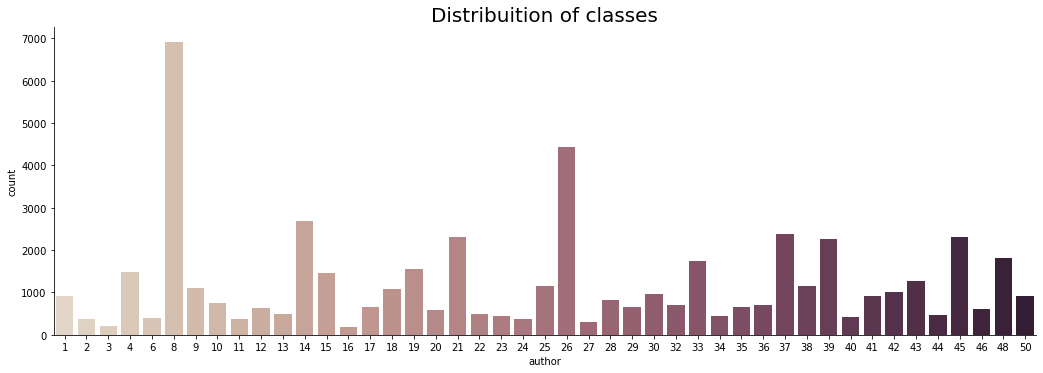

In [ ]:
print(Counter(list(dataset['author'].values)))
g =sns.catplot(x="author", kind="count", palette="ch:.25", data=dataset)
g.fig.set_size_inches(17, 5)
g.ax.set_title('Distribuition of classes', fontsize=20)

Dall'osservazione del contenuto delle novelle si nota che i testi appaiono in forma semplificata in lower case, senza la presenza di punteggiatura, accenti, ellisioni.
Pertanto, possiamo dedurre che i testi siano già pre-trattati



In [ ]:
prova = dataset.loc[1]
prova.text[:500]+"..."

'wish for solitude he was twenty years of age and in the possession of perfect health most youths like him would have the stillness of the and welcomed joyfully the first signs of that awakening that would come with the sunrise was sentimental the strangeness of the situation gave him a real delight he lay back in the comfortable seat stretched his legs and gave himself up to reverie his brain dwelt on the poetic quality of this peculiar place its history of which he had read much passed slowly t...'

# Preprocessing
In questa sezione andiamo a manipolare il nostro dataset: 

1.   verificando eventuali campi nulli
2.   suddividendo i termini dei testi in token (*tokenization*)
3.   eliminando le stopwords
4.   eseguendo lo stemming dei token

Le *stopwords* sono parole che, data la loro elevata frequenza e il loro basso contenuto informativo, sono ritenute poco significative in un problema di classificazione. Osservando più attentamente i termini all'interno delle novelle abbiamo deciso di realizzare una lista di stopword customizzata.

Lo *stemming* è un processo di trasformazione di un token dalla sua forma flessa alla forma radice (*stem*). L'obiettivo è quello di minimizzare l'effetto della presenza di variazioni morfologiche differenti che hanno però, lo stesso significato semantico. 

Il risultato di questo processo, ci ritornerà il dataset con le novelle tokenizzate.

In [ ]:
#verifica di campi null
dataset.isnull().sum()

text      0
author    0
dtype: int64

In [319]:
#lista stopwords
customized_list = ["â","a", "b", "c", "d", "e","f","g","h","l", "m", "n", "o", "p","q", "r", "s","t","u","v","w","z", "y", "j","k", "ah", "eh", "uh", "ahi", "oh", "ow", "ew", "aw"]
stopword_list = stopwords.words('english')+ list(string.punctuation) + customized_list

In [ ]:
dataset_tokenized = dataset.copy()

if os.path.exists("/Users/maryannrodriguez/Documents/Authorship Attribution Project/dataset/data_tokenized.csv"):
  dataset_tokenized = pd.read_pickle("/Users/maryannrodriguez/Documents/Authorship Attribution Project/dataset/data_tokenized.csv")

else:
  #tokenization
  for row in dataset_tokenized.itertuples():
    dataset_tokenized.at[row.Index, "text"]= word_tokenize(row.text)
  
  #stopwords
  for row in dataset_tokenized.itertuples():
    novel = [token for token in dataset_tokenized.at[row.Index, "text"] if token not in stopword_list]
    dataset_tokenized.at[row.Index, "text"]= novel

  #stemming
  stemmer = SnowballStemmer(language='english')
  for row in dataset_tokenized.itertuples():
    novel = [stemmer.stem(token) for token in row.text]
    dataset_tokenized.at[row.Index, "text"]= novel

  #save tokenized dataset on drive
  dataset_tokenized.to_pickle("./drive/MyDrive/ProgettoML/Dataset/data_tokenized.csv")

dataset_tokenized

,text,author
0,"[ou, time, listen, give, entir, stori, said, m...",1
1,"[wish, solitud, twenti, year, age, possess, pe...",1
2,"[skirt, blew, perfect, freedom, upper, part, w...",1
3,"[san, row, shop, opposit, impress, upon, visio...",1
4,"[hour, walk, tiresom, three, sensibl, english,...",1
...,...,...
53673,"[surround, search, whole, place, could, discov...",50
53674,"[giant, could, make, young, earthquak, angri, ...",50
53675,"[water, lake, bottom, hill, curl, kind, sympat...",50
53676,"[finger, thumb, exact, came, hand, never, mind...",50


# Split in Test e Traning set

In [4]:
labels_list = dataset_tokenized["author"]
X_train, X_test, y_train, y_test = train_test_split(dataset_tokenized, labels_list, test_size=0.3, random_state=1)
X_train

,text,author
42403,"[across, valley, fled, littl, river, bottom, p...",39
44760,"[speak, perhap, might, induc, stay, yet, hard,...",41
34368,"[hors, detach, background, night, window, came...",32
15526,"[wed, journey, discuss, might, perhap, take, d...",14
17241,"[marri, seem, natur, marri, year, pass, away, ...",15
...,...,...
50057,"[princ, death, know, father, account, must, th...",45
32511,"[hazard, strike, advantag, train, count, cost,...",29
5192,"[take, resid, mr, hous, alon, said, papa, part...",8
12172,"[univers, bow, mouth, tri, see, featur, withou...",10


Per avere una visuale più concreta della distribuzione delle classi nel training set e nel test set, osserviamo gli istogrammi riportati:

Text(0.5, 1.0, 'Distribuition of classes Training Set')

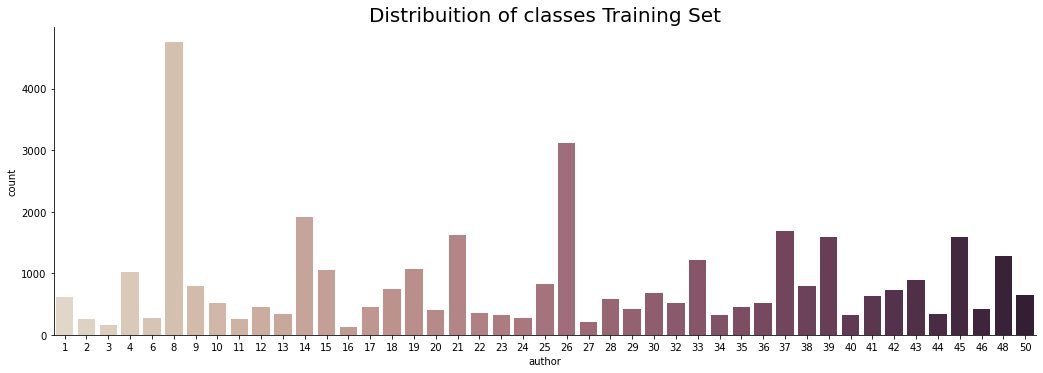

In [410]:
g =sns.catplot(x="author", kind="count", palette="ch:.25", data=X_train)
g.fig.set_size_inches(17, 5)
g.ax.set_title('Distribuition of classes Training Set', fontsize=20)

Text(0.5, 1.0, 'Distribuition of classes Test Set')

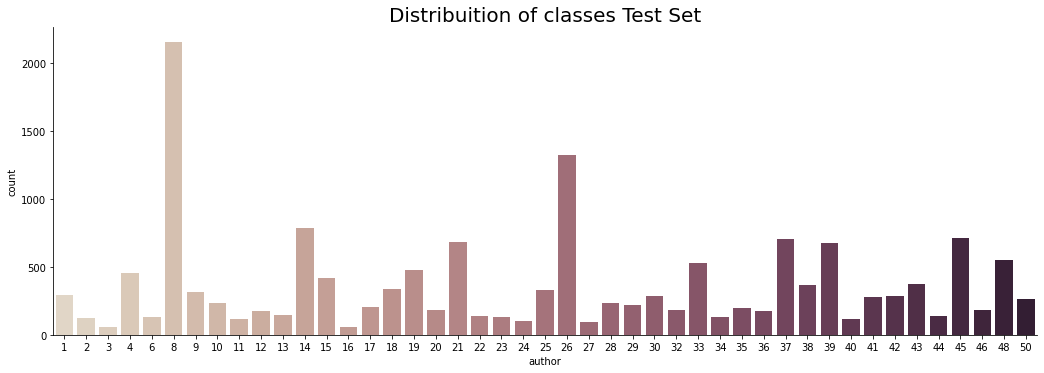

In [ ]:
g =sns.catplot(x="author", kind="count", palette="ch:.25", data=X_test)
g.fig.set_size_inches(17, 5)
g.ax.set_title('Distribuition of classes Test Set', fontsize=20)

## Ribilanciamento Training Set


La distribuzione delle classi del nostro dataset è notevolmente sbilanciata. Per affrontare il problema, abbiamo deciso di assegnare un peso alle classi da usare nelle funzioni di costo del modello, invece di usare una tecnica di resempling (Undersampling, Oversampling). 

Questa tecnica funziona per la maggior parte dei modelli ed è piuttosto semplice da realizzare in scikit-learn. Infatti è sufficiente aggiungere come parametro dei modelli **class_weight='balanced'**. La pesatura "*balanced*" utilizza il numero di elementi nella classe y per regolare automaticamente i pesi in modo inversamente proporzionale alle frequenze delle classi nei dati di input come 

$$ \frac{numSamples}{numClasses * np.bincount(y)}$$


## Analisi del training set
Analizziamo le frequenze dei termini all'interno della collezione e cerchiamo di avere un'idea su quali sono i termini più usati

In [ ]:
corpus_train = []
n_docs = len(X_train['text'])
for i in range(0, n_docs-1):
    corpus_train = corpus_train + X_train['text'].iloc[i]

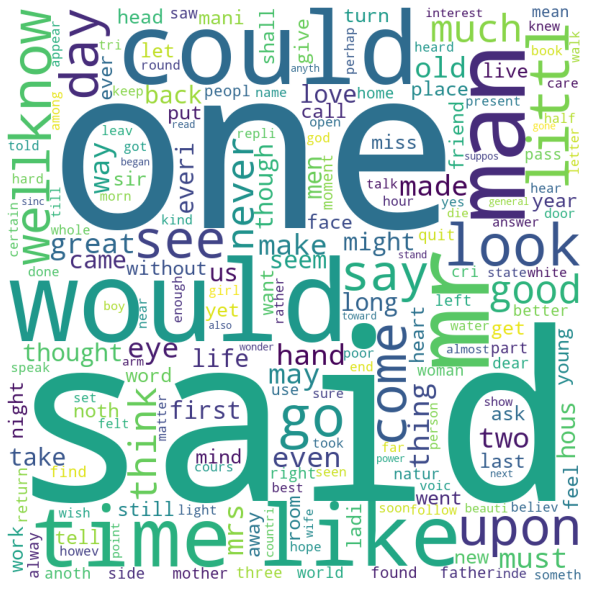

In [ ]:
from wordcloud import WordCloud 

words_count = Counter(corpus_train).most_common(200)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                relative_scaling=0.21,
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(dict(words_count))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

Osserviamo il numero di occorrenze dei primi 80 termini più frequenti

Text(0.5, 1.0, 'Word Frequencies')

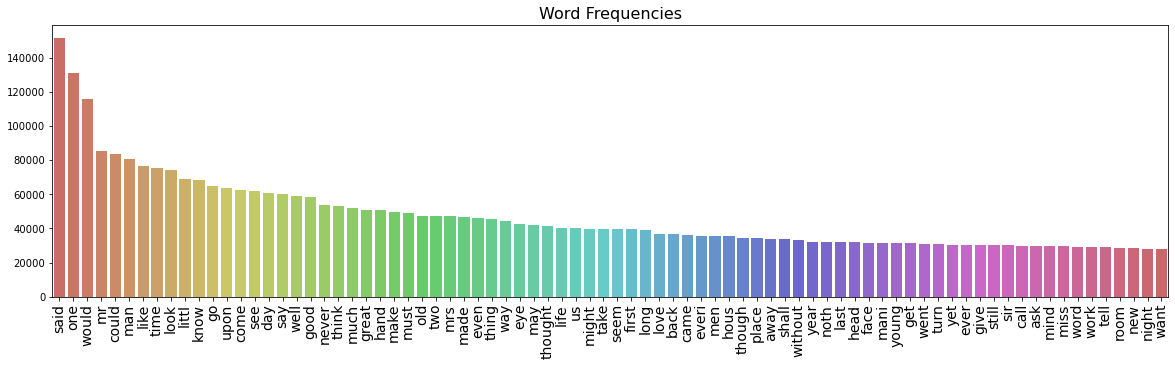

In [328]:
## plot frequenze
def word_frequency_barplot(df, nr_top_words=80):
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax

words_count_dataframe = pd.DataFrame.from_dict(dict(words_count), orient='index')
words_count_dataframe.rename(columns={0: 'count'}, inplace=True)

ax = word_frequency_barplot(words_count_dataframe)
ax.set_title("Word Frequencies", fontsize=16)

### Analisi degli autori 
Analizziamo in modo più dettagliato le nostre classi (*autori*):
1) Vediamo quanto spesso, gli scrittori hanno usato i termini riportati nell'istogramma qui sopra. In particolare, confrontiamo l'uso di questi termini dalle tre classi con più documenti rispetto alle 3 classi con meno documenti.
2) Rispetto ai loro termini più frequenti.
3) Confrontando i termini più frequenti in comune.

In [7]:
# Concateniamo tutti i testi di ciascun autore in una lista di token e creiamo un dizionario per mantenere i documenti di ogni autore
tokens_authors = dict.fromkeys(authors_list,[])
for i in authors_list:
    docs_auth = [item[0] for item in X_train.loc[X_train.author == i].values]
    tokens_authors[i] = np.concatenate(docs_auth)

In [14]:
#frequenze dei termini usati da ogni autore
word_frequencies = dict.fromkeys(authors_list,[])

for author in authors_list:
    word_frequencies[author] = Counter(tokens_authors[author]).most_common()


In [10]:
auth_counters= dict.fromkeys(authors_list,[])

for author in authors_list:
    auth_counters[author] = Counter(tokens_authors[author])

top80_terms =[term[0] for term in words_count[:80]] 
auth8_word_frequencies = {word: auth_counters[8][word] for word in top80_terms}
auth26_word_frequencies = {word: auth_counters[26][word] for word in top80_terms}
auth14_word_frequencies = {word: auth_counters[14][word] for word in top80_terms}

auth16_word_frequencies = {word: auth_counters[16][word] for word in top80_terms}
auth3_word_frequencies = {word: auth_counters[3][word] for word in top80_terms}
auth27_word_frequencies = {word: auth_counters[27][word] for word in top80_terms}

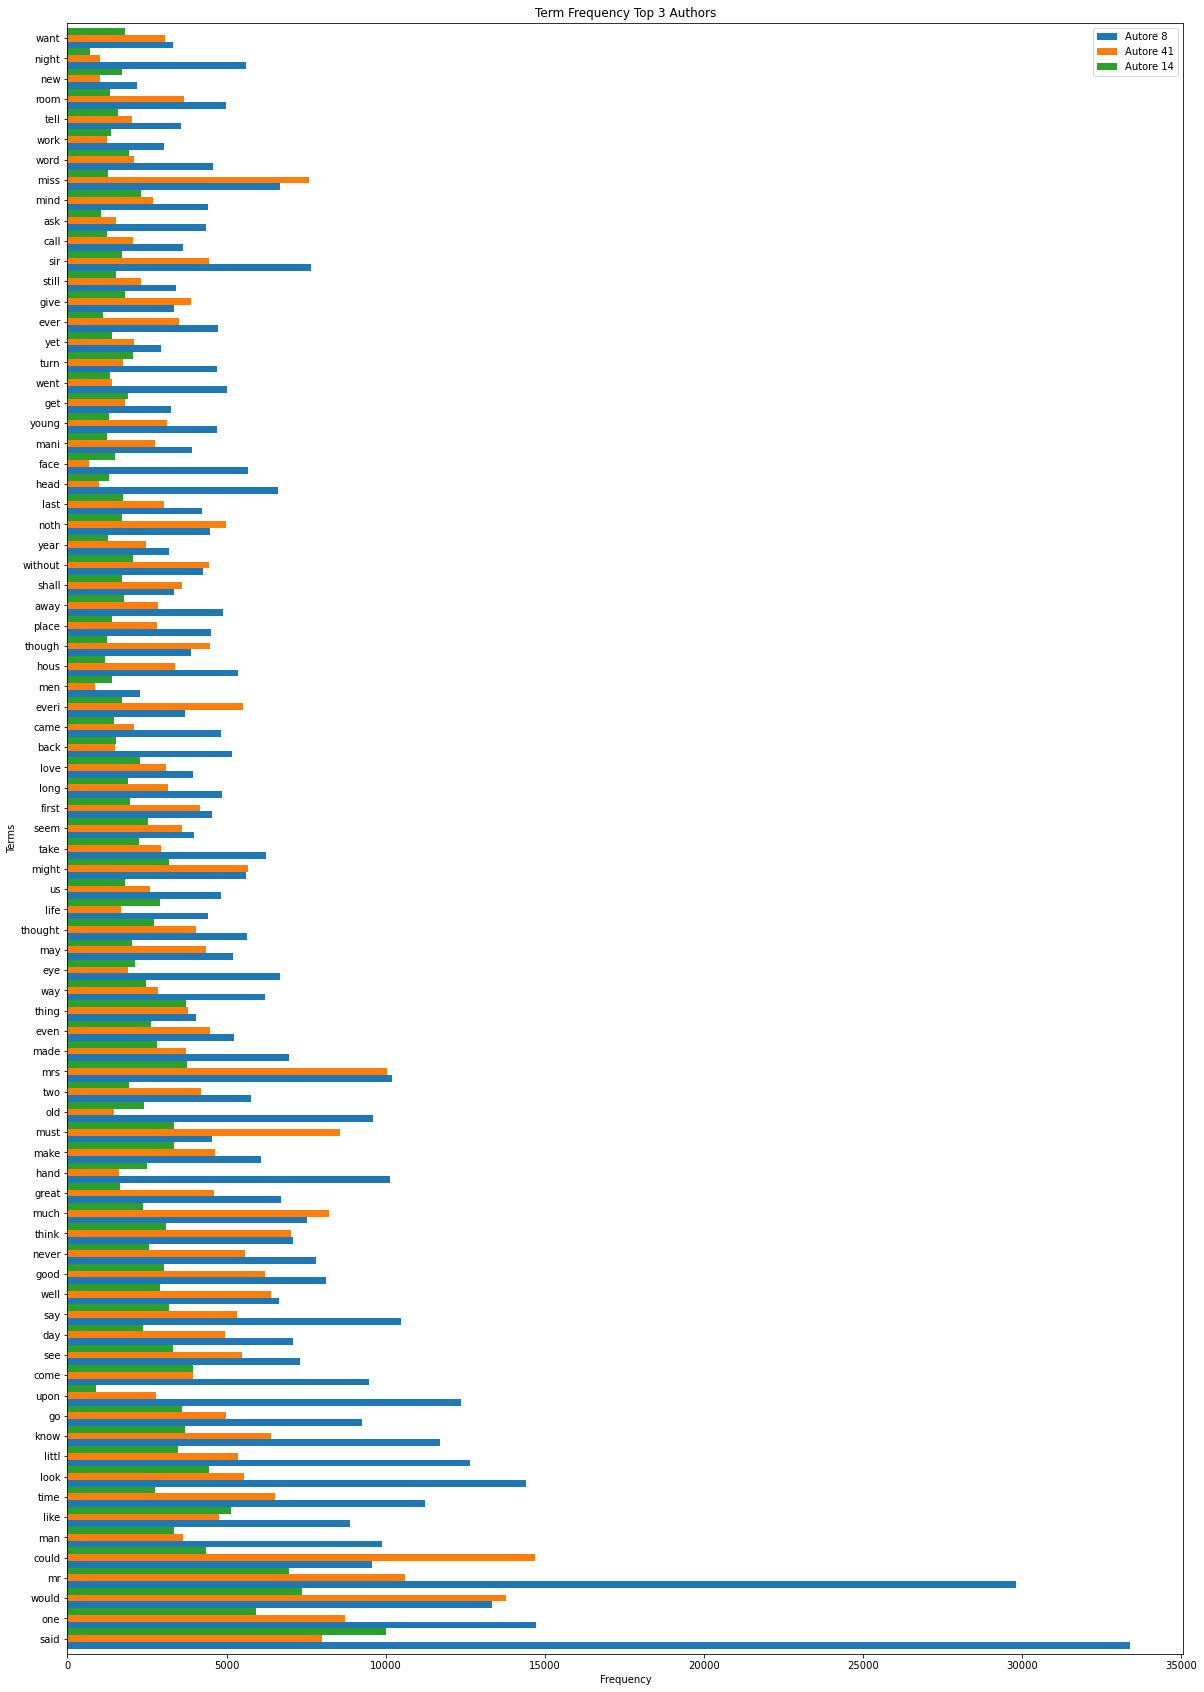

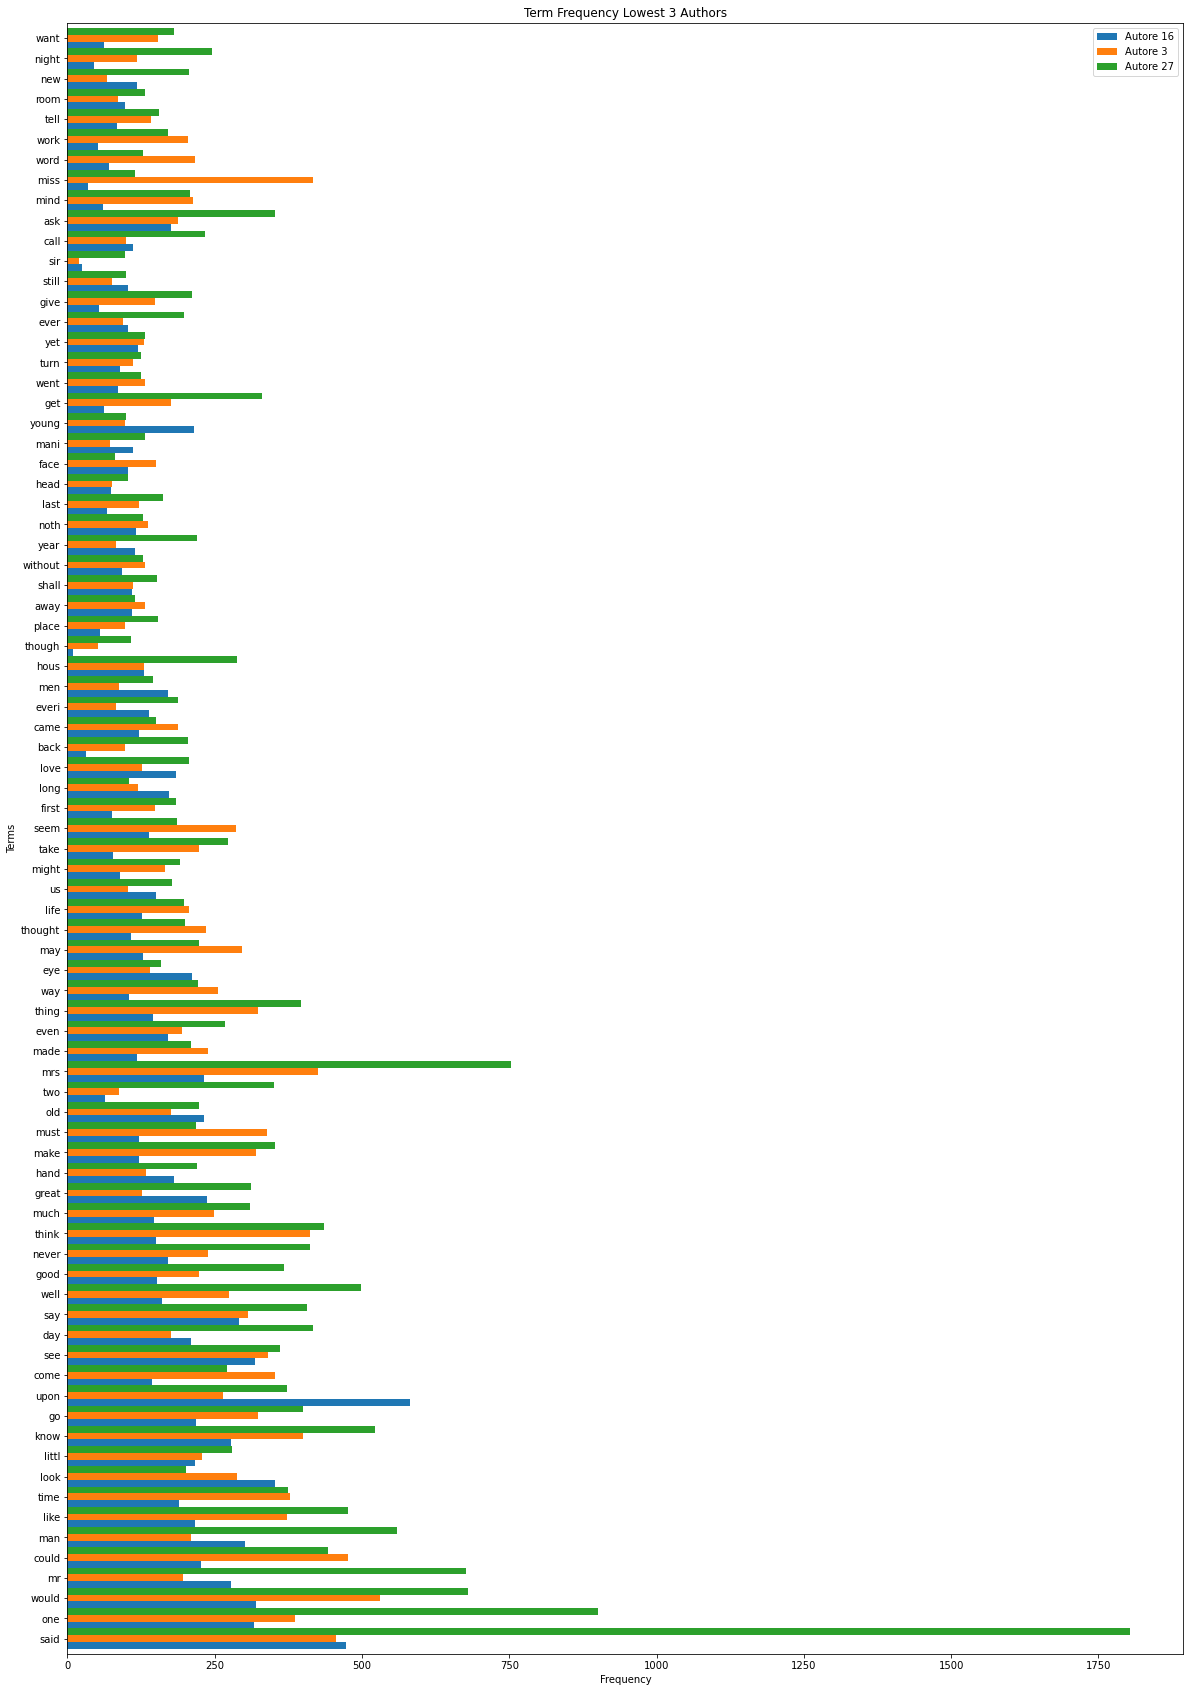

In [11]:
from turtle import width

#Histogramma top 3 authors
frequencies_df_1 = pd.DataFrame(index=top80_terms)
frequencies_df_1['Autore 8'] = list(map(lambda word:
                                      auth8_word_frequencies[word],
                                      frequencies_df_1.index))
frequencies_df_1['Autore 41'] = list(map(lambda word:
                                          auth26_word_frequencies[word],
                                          frequencies_df_1.index))
frequencies_df_1['Autore 14'] = list(map(lambda word:
                                              auth14_word_frequencies[word],
                                              frequencies_df_1.index))

frequencies_df_1.plot.barh(figsize=(20,30),width=1)
plt.title('Term Frequency Top 3 Authors')
plt.ylabel('Terms')
plt.xlabel('Frequency')
plt.show()   


#Histogramma lowest 3 authors
frequencies_df_2 = pd.DataFrame(index=top80_terms)
frequencies_df_2['Autore 16'] = list(map(lambda word:
                                      auth16_word_frequencies[word],
                                      frequencies_df_2.index))
frequencies_df_2['Autore 3'] = list(map(lambda word:
                                          auth3_word_frequencies[word],
                                          frequencies_df_2.index))
frequencies_df_2['Autore 27'] = list(map(lambda word:
                                              auth27_word_frequencies[word],
                                              frequencies_df_2.index))

frequencies_df_2.plot.barh(figsize=(20,30),width=1)
plt.title('Term Frequency Lowest 3 Authors')
plt.ylabel('Terms')
plt.xlabel('Frequency')
plt.show()      

Dal primo grafico, possiamo osservare che nonostante il numero di documenti associati agli autori, l'uso di alcuni dei termini più frequenti della collezione non è così ricorrente. Si guardi per esempio, il termine *upon* che non ha una frequenza così elevata.

Inoltre, da entrambi i grafici deduciamo che i nostri 45 scrittori preferiscono alcune parole rispetto ad altre, infatti c'è una notevole varianza nelle occorrenze dei termini usate da ogni autore.


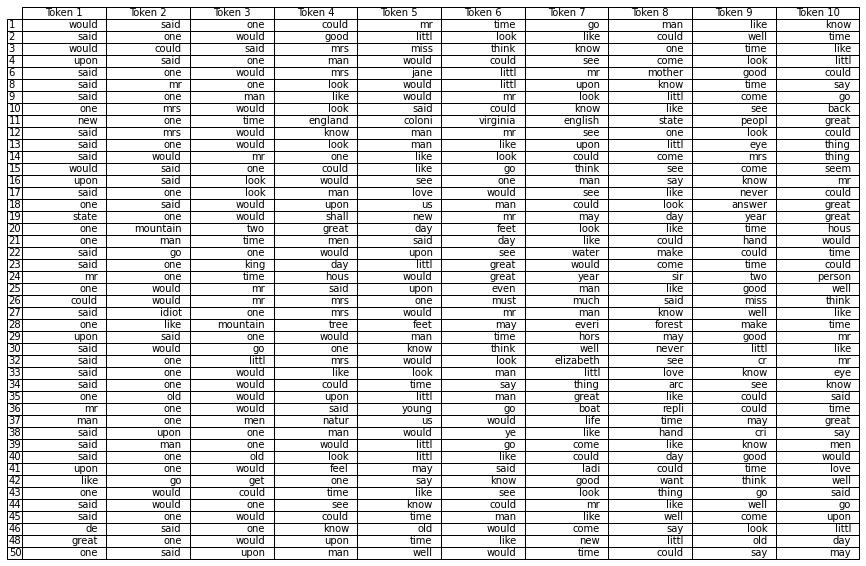

In [437]:
#prendiamo per ogni autore i primi 10 termini più frequenti
top10_words_list = []
for author in authors_list:
    list_tuples = word_frequencies[author][:10]
    top10_words_list.append(list(list(zip(*list_tuples))[0]))

# tabella 
fig, ax =plt.subplots(1,1, figsize=(15, 8))
column_labels=["Token 1", "Token 2", "Token 3", "Token 4", "Token 5", "Token 6", "Token 7", "Token 8", "Token 9", "Token 10"]
df=pd.DataFrame(top10_words_list,columns=column_labels)
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values,
        colLabels=df.columns,
        rowLabels=authors_list,
        loc="center")
plt.show()

La tabella mostra esattamente ciò che avevamo dedotto: la maggior parte dei termini più frequenti degli autori appartengono alla top 80 vista precedentemente. 
Tuttavia, dato il forte sbilanciamento delle classi, è possibile notare anche la presenza di termini più informativi dagli autori con poche novelle. Vediamo infatti per l'autore 11, i termini *england*, *virginia*, *state*. Oppure osserviamo addirittura nomi di persone come *jane* ed *elizabeth* per gli autori 6 e 32.

In [16]:
top_words_list = dict.fromkeys(authors_list,[])
for author in authors_list:
    list_tuples = word_frequencies[author][:1000]
    top_words_list[author] = (list(list(zip(*list_tuples))[0]))

Per identificare eventuali relazioni tra gli autori, facciamo una ricerca confrontando i loro termini più frequenti per rilevare termini comuni. In particolare, prendiamo per ogni autore gli 1000 termini più ricorrenti e per ogni coppia di autori si confronta se hanno almeno 740 termini in comune. 


In [17]:
# Ricerca autori simili
authors_similars = []
for auth1 in authors_list:
    for auth2 in authors_list:
        if auth1 != auth2:
            intersection = list(set(top_words_list[auth1]) & set(top_words_list[auth2]))
            if len(intersection) >= 740:
                authors_similars.append((auth1, auth2, intersection))

In [450]:
lists_similar_authors = [[] for i in range(45)] 
i = 0
for author in authors_list:
    l = [a_tuple[1] for a_tuple in authors_similars if a_tuple[0] == author] ## lista di autori simili per l'autore "author"
    if l: 
        lists_similar_authors[i] = [author] + [l]
    else:
        lists_similar_authors[i] = [author]
    i += 1

column_labels=[ "author","similar authors"]
df=pd.DataFrame(lists_similar_authors,columns=column_labels)
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values,
        colLabels=df.columns,
        rowLabels=authors_list,
        loc="center")
df[:]

,author,similar authors
0,1,"[8, 12, 25, 26, 30, 44, 45]"
1,2,"[4, 6, 8, 25, 38, 45]"
2,3,None
3,4,"[2, 8, 9, 13, 15, 17, 18, 21, 25, 33, 38, 45, 46]"
4,6,"[2, 25]"
5,8,"[1, 2, 4, 12, 14, 17, 25, 30, 32, 33, 38, 44, ..."
6,9,[4]
7,10,[32]
8,11,None
9,12,"[1, 8, 25]"


La scelta del valore della soglia pari a 740, influenza la scelta degli autori *simili*, permettendo di considerare anche i termini più informativi.  Qui sotto infatti vediamo riportati alcuni dei termini in comune tra gli autori 1 e 8:

In [22]:
print("Alcuni dei termini in comune tra gli autori 1 e 8:\n", authors_similars[0][2][:30])

Alcuni dei termini in comune tra gli autori 1 e 8:
 ['perfect', 'tell', 'lip', 'slowli', 'begin', 'paid', 'resolv', 'bright', 'depart', 'mark', 'children', 'second', 'sea', 'sort', 'go', 'forget', 'grow', 'sat', 'real', 'chamber', 'one', 'quiet', 'done', 'use', 'way', 'becam', 'five', 'reflect', 'take', 'love']


# Vettorizzazione tramite TF-IDF
Una volta terminata l'attività di preprocessing dei testi, segue la trasformazione dei contenuti in una forma tale da poter essere data in input agli algoritmi di machine learning.  Questi non sono in grado di analizzare direttamente le parole testuali, quindi deve essere svolta una conversione vettoriale numerica dei token.

In particolare è stata scelta la vettorizzazione basata su ***Term Frequency Inverse Document Frequency (tf-idf)***.

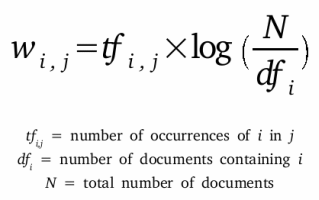

La weight di tf-idf aumenta proporzionalmente al numero di volte che il termine è contenuto nel documento, ma cresce in maniera inversamente proporzionale con la frequenza del termine nella collezione

In [ ]:
text_list_train = X_train['text'].tolist()
vectorizer = TfidfVectorizer()

for index, token in enumerate(text_list_train):
    text_list_train[index] = ' '.join(token)

data_train_vectorized = vectorizer.fit_transform(text_list_train)
Doc_Term_Matrix_Train = pd.DataFrame(data_train_vectorized.toarray(),columns= vectorizer.get_feature_names_out())
Doc_Term_Matrix_Train


,aa,aad,ab,abandon,abash,abbey,abid,abil,abject,abl,...,yonder,york,young,younger,youngest,youth,youv,zeal,zealous,zest
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.034793,...,0.0,0.0,0.024132,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.022933,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.068182,...,0.0,0.0,0.023645,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.038523,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37569,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37570,0.0,0.0,0.0,0.000000,0.0,0.000000,0.052682,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37571,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.045807,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37572,0.0,0.0,0.0,0.000000,0.0,0.092779,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
text_list_test = X_test['text'].tolist()  

for index, token in enumerate(text_list_test):
    text_list_test[index] = ' '.join(token)

#solo transform sul test set
data_test_vectorized = vectorizer.transform(text_list_test)
Doc_Term_Matrix_Test = pd.DataFrame(data_test_vectorized.toarray(),columns= vectorizer.get_feature_names_out())
Doc_Term_Matrix_Test

,aa,aad,ab,abandon,abash,abbey,abid,abil,abject,abl,...,yonder,york,young,younger,youngest,youth,youv,zeal,zealous,zest
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.018994,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.021136,0.0,0.0,0.000000,0.067091,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.026072,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.034508,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
16100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.032393,0.000000,0.0,0.0,0.0
16101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057762,...,0.0,0.0,0.040063,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
16102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.070417,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [ ]:
# Applicazione scaler Training e Test Set
max_abs_scaler = MaxAbsScaler()
X_train_scaled = max_abs_scaler.fit_transform(data_train_vectorized)
X_test_scaled = max_abs_scaler.transform(data_test_vectorized)

# Dimensionality Reduction
Per risolvere il problema della *curse of dimensionality*, vengono introdotte due tecniche : *Feature selection* e *Feature extraction*.

La *Feature extraction* consiste nell'identificare una proiezione del dataset su uno spazio di dimensione più piccolo in modo tale che la varianza degli elementi sia mantenuta il più possibile durante la proiezione.

LA *Feature selection * consiste nell'identificazione di un sottoinsieme di feature che sono le più significative rispetto al training set, eliminando le restanti features.



Queste due tecniche differiscono dalle features finali che vengono considerate. Nel caso della *feature selection* le features sono esattamente quelle di partenza, mentre nel caso di *feature extraction* le feature finali sono calcolate mediate una trasformazione delle feature originali.

## Features Extraction e PCA
Per la Feature Extraction si utilizza il metodo *TruncatedSvd*, che a differenza della PCA, lavora su matrici term count/tf-idf restituite dalla vettorizzazione, in particolare su set di dati sparsi di grandi dimensioni che non possono essere centrati.



Per determinare la dimensionalità da assegnare a TruncatedSVD abbiamo usato la funzione *select_n_components* che ci ritornata il numero di componenti che permette di mantenere il 70% di varianza. Inizialmente si è pensato di mantenere una varianza del 95%, ma si sono avuti problemi legati alla durata del train di alcuni modelli e pertanto si è preferito avere una varianza che ci permettesse sia di avere tempi ragionevoli di attesa dei risultati, sia di avere buone performance.

In [ ]:
# Scelta del miglior numero di componenti per la riduzione delle features 
tsvd = TruncatedSVD(n_components=X_train_scaled.shape[1]-1, algorithm='arpack')
X_train_tsvd = tsvd.fit(X_train_scaled)

In [ ]:
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [ ]:
best_n_components = select_n_components(tsvd_var_ratios, 0.70)
# 1761

In [ ]:
best_tsvd = TruncatedSVD(n_components=1761,algorithm='arpack')
X_train_tsvd = best_tsvd.fit_transform(X_train_scaled)
X_test_tsvd = best_tsvd.transform(X_test_scaled)

In [478]:
print ("La scelta di componenti fatta dall'algoritmo TruncatedSVD per il train set è: ", X_train_tsvd.shape)
print ("La scelta di componenti fatta dall'algoritmo TruncatedSVD per il test set è: ", X_test_tsvd.shape)

La scelta di componenti fatta dall'algoritmo TruncatedSVD per il train set è:  (37574, 1761)
La scelta di componenti fatta dall'algoritmo TruncatedSVD per il test set è:  (16104, 1761)


## Features Selection con Mutual Information
Per determinate i termini più rilevanti per la classificazione, ossia quelli la quale presenza o assenza in un documento caratterizzano la classe del documento viene utilizzata la *mutual information*, un metodo della Feature selection.

La funzione *Selectkbest* prende due parametri: la mutual_info_classif che misura la dipendenza tra le variabili e il paramentro k che indica il numero di features che verranno selezionate.

Per la scelta del valore di k, dato l'elevato numero di features, abbiamo deciso di dimezzarne il numero.

In [120]:
mic = SelectKBest(mutual_info_classif,k=2936)
X_train_fs = mic.fit_transform(X_train_scaled,y_train)
X_test_fs = mic.transform(X_test_scaled)


In [479]:
print ("La scelta di componenti fatta dall'algoritmo Mutual Information per il train set è: ", X_train_fs.shape)
print ("La scelta di componenti fatta dall'algoritmo Mutual Information  per il test set è: ", X_test_fs.shape)

La scelta di componenti fatta dall'algoritmo Mutual Information per il train set è:  (37574, 2936)
La scelta di componenti fatta dall'algoritmo Mutual Information  per il test set è:  (16104, 2936)


# Multinomial Naive Bayes
Il Naive Bayes è un classificatore probabilistico basato sull'applicazione del teorema di Bayes con assunzioni di indipendenza forti tra le feature.

Utilizziamo il classificatore multinomiale Naive Bayes, che non può essere applicato nel caso del dataset processato con la funzione di feature extraction TruncatedSVD, poichè la funzione genera numeri negativi che non vengono accettati dal MultinomialNB. 
> Dalla documentazione di scikit-learn: SVD soffre di un problematica detta "***sign indeterminacy***”", il che significa che il segno delle componenti e l'output della trasformazione dipendono dall'algoritmo e dal random state.

Per tale motivo, applicheremo il modello MultinomialNB sul train set scaled e nel sul set con la feature selection.

In [347]:
list_acc_mnb = {
    "simple": None,
    "fs": None
}

list_f1score_mnb= {
    "simple": None,
    "fs": None
}

Per il tuning dei parametri dei modelli, usiamo la funzione ***RandomizedSearchCV()***, che esegue Cross Validation. In particolare impostando il parametro cv=5, eseguiamo un 5-fold cross validation.
*RandomizedSearch* quindi dividerà ulteriormente i dati di train in train e test per fare il tuning dei iperparametri che gli sono stati passati. Infine, si esegue il fit del modello all'intero train set con i migliori parametri trovati.

Per questo modello, il tuning viene eseguito sul paramentro $\alpha $ per lo smoothing.

In [345]:
params = { 'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] }

mnb = RandomizedSearchCV(MultinomialNB(), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
mnb.fit(X_train_scaled,y_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0]},
                   return_train_score=True, scoring='f1_macro')

best parameters: {'alpha': 0.1}
best score:      0.87412 (+/-0.00276)


,param_alpha,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.1,0.874119,0.002764,1,0.934857,0.000271
1,0.2,0.871611,0.002459,2,0.928381,0.000342
2,0.3,0.867893,0.002943,3,0.924324,0.000671
3,0.4,0.861685,0.002592,4,0.921011,0.000382
4,0.5,0.855701,0.004533,5,0.917575,0.000766
5,0.6,0.848452,0.003240,6,0.913459,0.000465
6,0.7,0.840334,0.004410,7,0.908201,0.000580
7,0.8,0.833053,0.004860,8,0.902702,0.000512
8,0.9,0.823754,0.005117,9,0.895330,0.001011
9,1.0,0.816171,0.005003,10,0.887497,0.001355


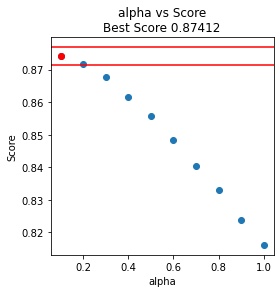

In [346]:
RandomizedSearch_table_plot(mnb, param_list=["alpha"],negative=False)

In [420]:
y_pred_mnb = mnb.predict(X_test_scaled)
show_results(y_test, y_pred_mnb)
list_acc_mnb['simple'] = accuracy_score(y_test, y_pred_mnb)
list_f1score_mnb['simple'] = f1_score(y_test, y_pred_mnb, average='weighted')

Accuracy:  0.8831346249379036
Avg Precision 0.8923996473539033
Avg Recall 0.8831346249379036
Avg F1-score 0.885398606087529


## Multinomial Naive Bayes con Feature Selection

In [352]:
params = { 'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] }

mnb_fs = RandomizedSearchCV(MultinomialNB(), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
mnb_fs.fit(X_train_fs,y_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0]},
                   return_train_score=True, scoring='f1_macro')

best parameters: {'alpha': 0.1}
best score:      0.84694 (+/-0.00314)


,param_alpha,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.1,0.846937,0.003144,1,0.895574,0.000834
1,0.2,0.845436,0.002689,2,0.892277,0.000571
2,0.3,0.843284,0.003112,3,0.889361,0.000564
3,0.4,0.839264,0.003283,4,0.886353,0.000692
4,0.5,0.836747,0.004200,5,0.883730,0.000756
5,0.6,0.832834,0.003659,6,0.880847,0.000843
6,0.7,0.829490,0.003564,7,0.878106,0.001173
7,0.8,0.825612,0.003756,8,0.874735,0.000925
8,0.9,0.821156,0.004005,9,0.870892,0.000821
9,1.0,0.816377,0.005748,10,0.867294,0.000726


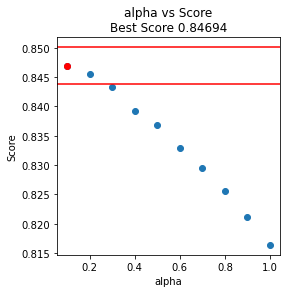

In [354]:
RandomizedSearch_table_plot(mnb_fs, param_list=["alpha"],negative=False)

In [421]:
y_pred_mnb_fs = mnb_fs.predict(X_test_fs)
show_results(y_test, y_pred_mnb_fs)
list_acc_mnb['fs'] = accuracy_score(y_test, y_pred_mnb_fs)
list_f1score_mnb['fs'] = f1_score(y_test, y_pred_mnb_fs, average='weighted')

Accuracy:  0.8578614008941878
Avg Precision 0.8708299430501948
Avg Recall 0.8578614008941878
Avg F1-score 0.860754443267079


## Confronto

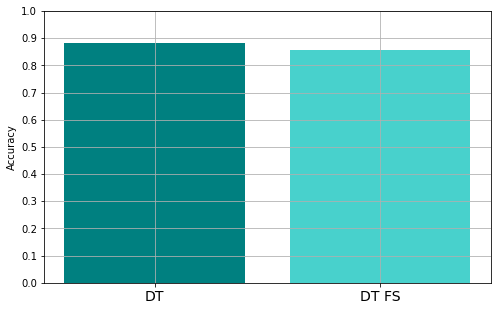

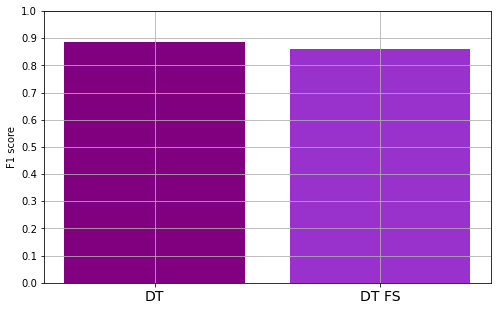

In [370]:
plot_glob_accuracy(['DT', 'DT FS'], list_acc_mnb.values())
plot_glob_f1score(['DT', 'DT FS'], list_f1score_mnb.values())

# Decision trees

I Decision Trees sono un modello di apprendimento supervisionato non parametrico utilizzato per la classificazione e la regressione. L'obiettivo è creare un modello che predica il valore di una variabile target apprendendo semplici regole decisionali dedotte dalle caratteristiche dei dati.

Queste regole decisionali consentono di partizionare in modo ricorsivo lo spazio delle features.

Supponiamo adesso di considerare un nodo e di volerlo partizionare.

L'idea è quella di andare a selezionare la feature e la soglia tali che una determinata misura è massimizzata nell'intersezione del training set con ognuna delle sottoregioni ottenute dalla partizione. Questa misura è una misura di impurità, e deve essere minimizzata.

In particolare, per eseguire il tuning dei parametri abbiamo considerato le seguenti misure di impurità:


1) Gini Index
$$ G_S = 1 - \sum_{i=1}^{k} \left( \frac{\vert S_i \vert}{\vert S \vert} \right)^2$$
2) Entropy
$$ H_s = -\sum_{i=1}^{k} \frac{\vert S_i \vert}{\vert S \vert} \hspace{1mm} log_2 \left( \frac{\vert S_i \vert}{\vert S \vert} \right) $$

Dove $S$ è l'insieme degli elementi del tranining set, $S_i \subseteq S $ è l'insieme di elementi di $S$ appartenenti alla classe $i$ e $k$ è il numero di classi.

Per limitare la profondità dell'albero è stato eseguito anche un tuning rispetto al parametro *max_depth*.
 

 





In [182]:
list_acc_dt = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

list_f1score_dt = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

In [82]:
params = { 'criterion':['gini','entropy'],
            'max_depth':[8,16,20,32] 
          }
rscv_dft = RandomizedSearchCV(DecisionTreeClassifier(class_weight='balanced'), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
rscv_dft.fit(X_train_scaled,y_train)

best parameters: {'max_depth': 32, 'criterion': 'gini'}
best score:      0.35680 (+/-0.00217)


,param_max_depth,param_criterion,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,32,gini,0.356801,0.002165,1,0.603262,0.011491
2,20,gini,0.267632,0.008882,2,0.373051,0.013031
7,32,entropy,0.255300,0.002670,3,1.000000,0.000000
6,20,entropy,0.254946,0.004038,4,0.973558,0.013653
5,16,entropy,0.238921,0.001685,5,0.849734,0.009559
1,16,gini,0.229124,0.008374,6,0.302522,0.011648
4,8,entropy,0.175484,0.003798,7,0.220672,0.005114
0,8,gini,0.108683,0.005151,8,0.126254,0.005075


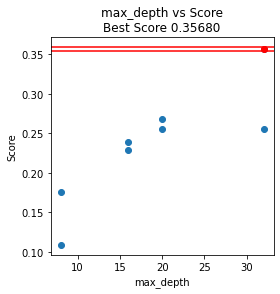

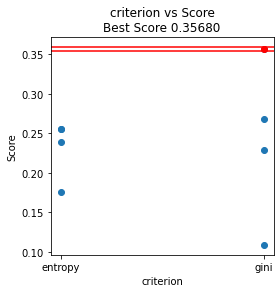

In [83]:
RandomizedSearch_table_plot(rscv_dft, param_list=["max_depth","criterion"],negative=False)

In [412]:
y_pred_dft = rscv_dft.predict(X_test_scaled)
show_results(y_test, y_pred_dft)
list_acc_dt['simple'] = accuracy_score(y_test, y_pred_dft)
list_f1score_dt['simple'] = f1_score(y_test, y_pred_dft, average='weighted')

Accuracy:  0.348050173869846
Avg Precision 0.46041308651993856
Avg Recall 0.348050173869846
Avg F1-score 0.37238886009742983


## Decision Tree con TruncatedSVD

In [ ]:
params = { 'criterion':['gini','entropy'],
            'max_depth':[8,16,20,32] 
          }
rscv_dtc_tsvd= RandomizedSearchCV(DecisionTreeClassifier(class_weight='balanced'), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
rscv_dtc_tsvd.fit(X_train_tsvd,y_train)

best parameters: {'max_depth': 16, 'criterion': 'entropy'}
best score:      0.28258 (+/-0.00298)


,param_max_depth,param_criterion,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
5,16,entropy,0.282583,0.002980,1,0.993618,0.001668
6,20,entropy,0.282549,0.001790,2,0.999996,0.000009
7,32,entropy,0.281897,0.002677,3,1.000000,0.000000
1,16,gini,0.281423,0.002219,4,0.665413,0.017157
3,32,gini,0.280703,0.004794,5,0.975879,0.002574
2,20,gini,0.280574,0.002007,6,0.817067,0.007948
4,8,entropy,0.260328,0.005408,7,0.308099,0.005446
0,8,gini,0.231038,0.006958,8,0.272813,0.011719


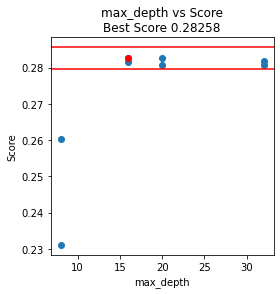

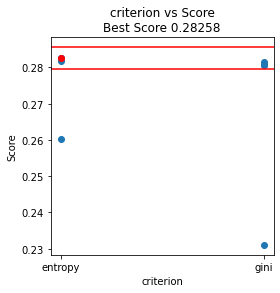

In [101]:
RandomizedSearch_table_plot(rscv_dtc_tsvd, param_list=["max_depth","criterion"],negative=False)

In [422]:
y_pred_dft_tsvd = rscv_dtc_tsvd.predict(X_test_tsvd)
show_results(y_test, y_pred_dft_tsvd)
list_acc_dt['tsvd'] = accuracy_score(y_test, y_pred_dft_tsvd)
list_f1score_dt['tsvd'] = f1_score(y_test, y_pred_dft_tsvd,average='weighted')

Accuracy:  0.39629905613512173
Avg Precision 0.39797479792235735
Avg Recall 0.39629905613512173
Avg F1-score 0.3968543804300055


## Decision Tree con Feature Selection

In [ ]:
#usiamo sempre gli stessi parametri 
params = { 'criterion':['gini','entropy'],
            'max_depth':[8,16,20,32] 
          }
rscv_dtc_fs = RandomizedSearchCV(DecisionTreeClassifier(class_weight='balanced'), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
rscv_dtc_fs.fit(X_train_fs,y_train)
#26min51

best parameters: {'max_depth': 32, 'criterion': 'gini'}
best score:      0.34712 (+/-0.00962)


,param_max_depth,param_criterion,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,32,gini,0.347116,0.009620,1,0.634513,0.013912
2,20,gini,0.278012,0.009803,2,0.416335,0.010481
7,32,entropy,0.252347,0.001768,3,1.000000,0.000000
6,20,entropy,0.249787,0.003130,4,0.980366,0.007076
5,16,entropy,0.237770,0.006603,5,0.851302,0.013432
1,16,gini,0.230019,0.009246,6,0.322293,0.012548
4,8,entropy,0.175230,0.004187,7,0.220755,0.003042
0,8,gini,0.109559,0.003701,8,0.130571,0.004836


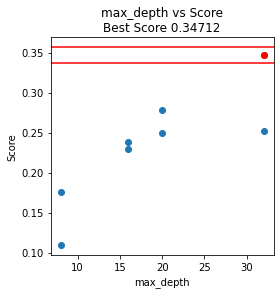

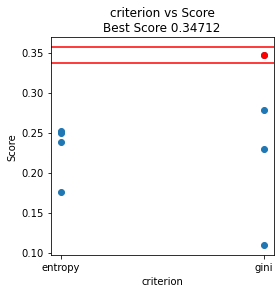

In [80]:
RandomizedSearch_table_plot(rscv_dtc_fs, param_list=["max_depth","criterion"],negative=False)

In [423]:
y_pred_dft_fs = rscv_dtc_fs.predict(X_test_fs)
show_results(y_test, y_pred_dft_fs)
list_acc_dt['fs'] = accuracy_score(y_test, y_pred_dft_fs)
list_f1score_dt['fs'] = f1_score(y_test, y_pred_dft_fs, average='weighted')

Accuracy:  0.35873075012419275
Avg Precision 0.43144127011584105
Avg Recall 0.35873075012419275
Avg F1-score 0.3766895185576007


## Confronto 

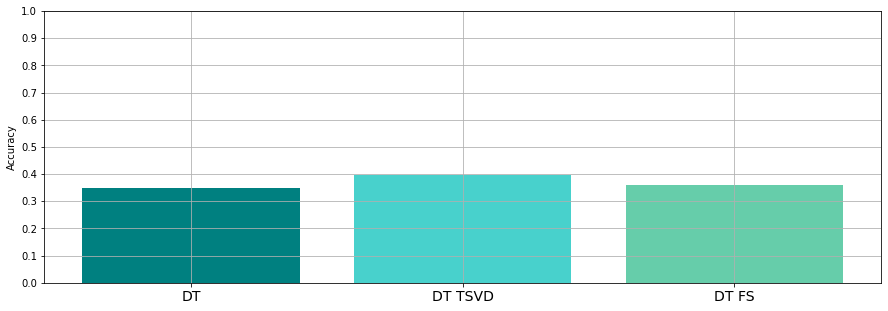

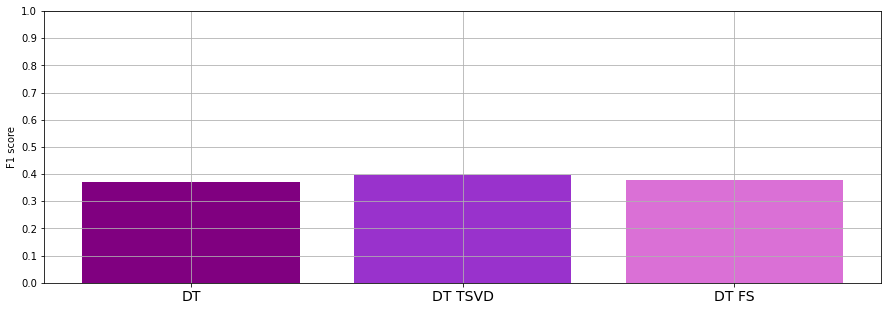

In [215]:
plot_glob_accuracy(['DT', 'DT TSVD', 'DT FS'], list_acc_dt.values())
plot_glob_f1score(['DT', 'DT TSVD', 'DT FS'], list_f1score_dt.values())

# Random Forest

Le Random Forest o random decision Forest è un metodo ensamble per la classificazione e la regressione, basato sull'utilizzo di molteplici alberi decisionali durante l'addestramento, andando a correggere la tendenza degli alberi decisionali di adattarsi in modo eccessivo al train set.



La creazione di una foresta casuale di alberi decisionali avviene nel seguente modo:

Per ogni albero b= 1,.....,B si genera un boootstrap sample dal training set.

Si fa crescere un albero di decisione Tb nel sample con le seguenti operazioni.



1. si seleziona m variabili in maniera randomica

2. Si sceglie la "migliore " rispetto a queste variabili

3. si divide il nodo in due figli



L'output che otteniamo è la collezione di alberi T1,T2, ...TB.



Rispetto agli alberi decisionali visti precedentemente, la RandomizedSearchCV non va più a ricercare i migliori parametri associati alla profondità degli alberi e all'impurità, ma ricerca il miglior valore del parametro "n_estimator", ossia il numero di albero decisionali da prendere in considerazione.

 Per la profondità da dare agli alberi, abbiamo deciso di riprendere il valori ritornato dalla RandomizedSearchCV eseguita sugli alberi decisionali.

In [216]:
list_acc_rf = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

list_f1score_rf = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

In [109]:
params = {  "n_estimators" : [64,128,256,512] }
rscv_rfc = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced',max_depth=32), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
rscv_rfc.fit(X_train_scaled,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    max_depth=32),
                   n_jobs=-1,
                   param_distributions={'n_estimators': [64, 128, 256, 512]},
                   return_train_score=True, scoring='f1_macro')

best parameters: {'n_estimators': 512}
best score:      0.74773 (+/-0.00990)


,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,512,0.747729,0.009903,1,0.999898,0.000043
2,256,0.736031,0.009102,2,0.999924,0.000026
1,128,0.712614,0.006682,3,0.999735,0.000081
0,64,0.665110,0.007847,4,0.999405,0.000095


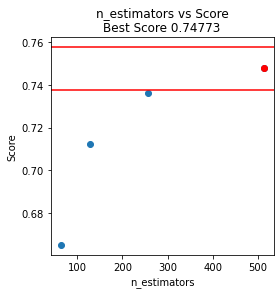

In [111]:
RandomizedSearch_table_plot(rscv_rfc, param_list=["n_estimators"],negative=False)

In [424]:
y_pred_rfc = rscv_rfc.predict(X_test_scaled)
show_results(y_test, y_pred_rfc)
list_acc_rf['simple'] = accuracy_score(y_test, y_pred_rfc)
list_f1score_rf['simple'] = f1_score(y_test, y_pred_rfc, average='weighted')

Accuracy:  0.7837183308494784
Avg Precision 0.8224057008609822
Avg Recall 0.7837183308494784
Avg F1-score 0.7796733225117279


## Random Forest con TruncatedSVD

In [ ]:
rscv_rfc_tsvd = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced',max_depth=20), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
rscv_rfc_tsvd.fit(X_train_tsvd,y_train)

best parameters: {'n_estimators': 50, 'criterion': 'gini'}
best score:      0.38108 (+/-0.00620)


,param_n_estimators,param_criterion,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
2,50,gini,0.381078,0.006196,1,0.998551,0.000202
7,30,gini,0.317438,0.009816,2,0.992887,0.000858
6,20,gini,0.265105,0.003547,3,0.975032,0.003134
8,15,gini,0.239055,0.004257,4,0.948218,0.002472
3,10,gini,0.194749,0.008159,5,0.879672,0.013414
5,45,entropy,0.188566,0.008189,6,1.000000,0.000000
0,50,entropy,0.183355,0.006737,7,1.000000,0.000000
1,35,entropy,0.176267,0.005786,8,1.000000,0.000000
4,25,entropy,0.162300,0.003704,9,1.000000,0.000000
9,20,entropy,0.157401,0.004131,10,0.999965,0.000035


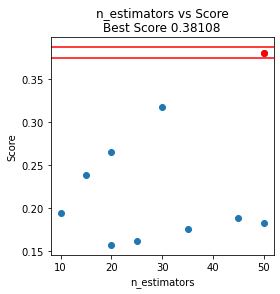

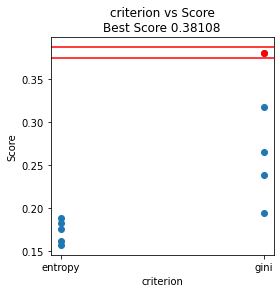

In [ ]:
RandomizedSearch_table_plot(rscv_rfc_tsvd, param_list=["n_estimators","criterion"],negative=False)

In [425]:
y_pred_rfc_tsvd = rscv_rfc_tsvd.predict(X_test_tsvd)
show_results(y_test, y_pred_rfc_tsvd)
list_acc_rf['tsvd'] = accuracy_score(y_test, y_pred_rfc_tsvd)
list_f1score_rf['tsvd'] = f1_score(y_test, y_pred_rfc_tsvd, average='weighted')

Accuracy:  0.7485096870342772
Avg Precision 0.7786498036074866
Avg Recall 0.7485096870342772
Avg F1-score 0.7319152617665461


## Random Forest con Feature Selection

In [104]:
params = { "n_estimators" : [64,128,256,512]}
rscv_rfc_fs = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced',max_depth=32), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
rscv_rfc_fs.fit(X_train_fs,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    max_depth=32),
                   n_jobs=-1,
                   param_distributions={'n_estimators': [64, 128, 256, 512]},
                   return_train_score=True, scoring='f1_macro')

best parameters: {'n_estimators': 512}
best score:      0.71625 (+/-0.01100)


,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,512,0.716250,0.011004,1,0.999911,0.000047
2,256,0.703150,0.009398,2,0.999884,0.000057
1,128,0.686235,0.008169,3,0.999857,0.000039
0,64,0.650470,0.008391,4,0.999650,0.000057


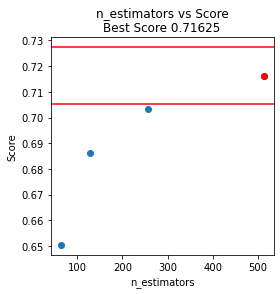

In [106]:
RandomizedSearch_table_plot(rscv_rfc_fs, param_list=["n_estimators"],negative=False)

In [426]:
y_pred_rfc_fs = rscv_rfc_fs.predict(X_test_fs)
show_results(y_test, y_pred_rfc_fs)
list_acc_rf['fs'] = accuracy_score(y_test, y_pred_rfc_fs)
list_f1score_rf['fs'] = f1_score(y_test, y_pred_rfc_fs, average='weighted')

Accuracy:  0.7642200695479384
Avg Precision 0.8170823075252456
Avg Recall 0.7642200695479384
Avg F1-score 0.7591316640246405


## Confronto Random Forest

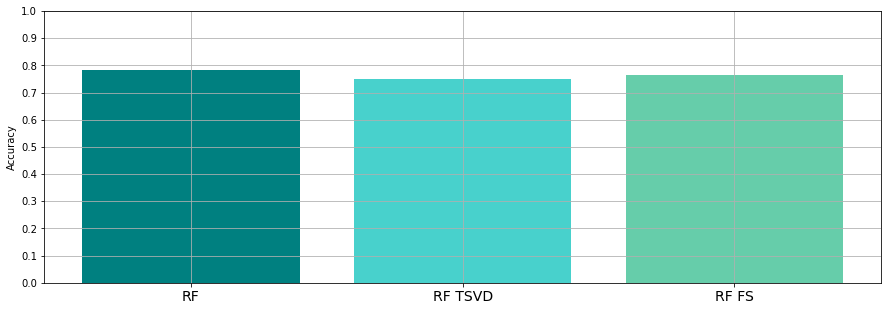

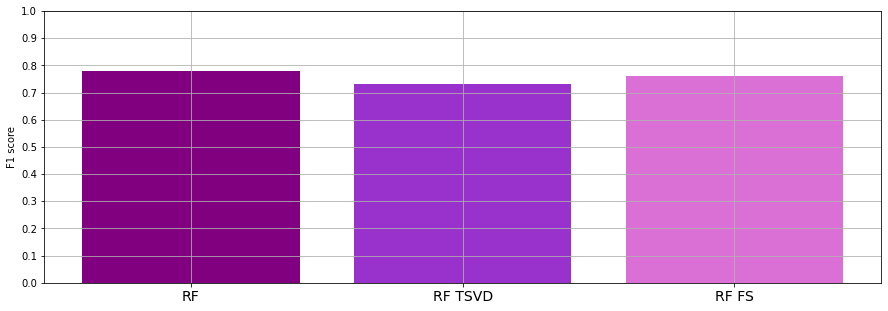

In [232]:
plot_glob_accuracy(['RF', 'RF TSVD', 'RF FS'], list_acc_rf.values())
plot_glob_f1score(['RF', 'RF TSVD', 'RF FS'], list_f1score_rf.values())

# Adaboost

AdaBoost è un metodo Ensamble di tipo Boosting, la cui idea alla base è quella di adattare una sequenza di *weak learners* su versioni ripetutamente modificate dei dati. I modelli sono addestrati in sequenza, e ogni modello è addestrato utilizzando una versione pesata del training set. 
Il peso associato ad ogni elemento del training set indica quanto rilevante è quell'elemento, ovvero di quanto la sua misclassificazione di va ad impattare nella funzione di costo.

I pesi per i vari elementi sono calcolati in funzione delle performance dei modelli precedenti: i punti mal classificati ricevono dei pesi maggiori. Ogni modello viene quindi addestrato con un particolare dataset, ottenuto in funzione dei modelli precedenti.

Le predizioni vengono effettuate tramite uno schema di maggioranza pesata rispetto a tutti i modelli.

I weak learners presi in considerazione sono i Decision Tree con parametri *max_depth* pari a quelli ottenuti dai tuning eseguiti nel modello Decision Tree precedente.
In questo caso, la ricerca dei migliori parametri avviene solo per il **numero di stimatori**.


In [236]:
list_acc_adb = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

list_f1score_adb = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

In [ ]:
params = { "n_estimators" : [50, 100, 200, 250]}
adb = RandomizedSearchCV(AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced')), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
adb.fit(X_train_scaled,y_train)

best parameters: {'n_estimators': 250}
best score:      0.41422 (+/-0.00345)


,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,250,0.414218,0.003451,1,1.0,0.0
0,50,0.413925,0.001537,2,1.0,0.0
2,200,0.413127,0.003398,3,1.0,0.0
1,100,0.412408,0.003283,4,1.0,0.0


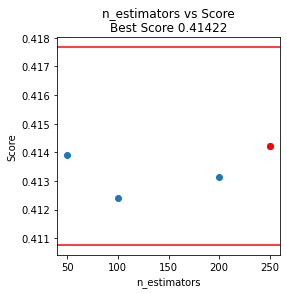

In [ ]:
RandomizedSearch_table_plot(adb, param_list=["n_estimators"],negative=False)

In [427]:
y_pred_adb = adb.predict(X_test_scaled)
show_results(y_test, y_pred_adb)
list_acc_adb['simple'] = accuracy_score(y_test, y_pred_adb)
list_f1score_adb['simple'] = f1_score(y_test, y_pred_adb, average='weighted')

Accuracy:  0.45119225037257826
Avg Precision 0.4502814952143168
Avg Recall 0.45119225037257826
Avg F1-score 0.44946344021730456


## Adaboost con Truncated SVD

In [52]:
params = { "n_estimators" : [50, 100, 200, 250]}
adb_tsvd = RandomizedSearchCV(AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced')), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
adb_tsvd.fit(X_train_tsvd,y_train)

best parameters: {'n_estimators': 250}
best score:      0.28289 (+/-0.00398)


,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,250,0.282887,0.003980,1,1.0,0.0
2,200,0.282307,0.003162,2,1.0,0.0
1,100,0.281927,0.003598,3,1.0,0.0
0,50,0.281142,0.002951,4,1.0,0.0


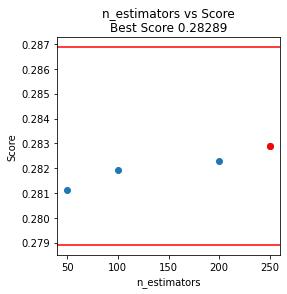

In [53]:
RandomizedSearch_table_plot(adb_tsvd, param_list=["n_estimators"],negative=False)

In [428]:
y_pred_adb_tsvd = adb_tsvd.predict(X_test_tsvd)
show_results(y_test, y_pred_adb_tsvd)
list_acc_adb['tsvd'] = accuracy_score(y_test, y_pred_adb_tsvd)
list_f1score_adb['tsvd'] = f1_score(y_test, y_pred_adb_tsvd, average='weighted')

Accuracy:  0.40021112767014405
Avg Precision 0.40224671395176287
Avg Recall 0.40021112767014405
Avg F1-score 0.4008067094650701


## Adaboost con Feature Selection

In [ ]:
adb_fs = RandomizedSearchCV(AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced')), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
adb_fs.fit(X_train_fs,y_train)

best parameters: {'n_estimators': 250}
best score:      0.41422 (+/-0.00345)


,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,250,0.414218,0.003451,1,1.0,0.0
0,50,0.413925,0.001537,2,1.0,0.0
2,200,0.413127,0.003398,3,1.0,0.0
1,100,0.412408,0.003283,4,1.0,0.0


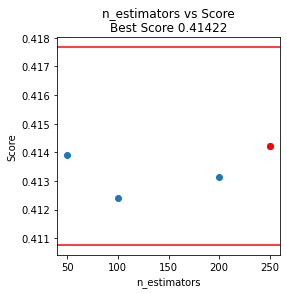

In [ ]:
RandomizedSearch_table_plot(adb, param_list=["n_estimators"],negative=False)

In [429]:
y_pred_adb_fs = adb_fs.predict(X_test_fs)
show_results(y_test, y_pred_adb_fs)
list_acc_adb['fs'] = accuracy_score(y_test, y_pred_adb_fs)
list_f1score_adb['fs'] = f1_score(y_test, y_pred_adb_fs, average='weighted')

Accuracy:  0.4307004470938897
Avg Precision 0.42859911477322
Avg Recall 0.4307004470938897
Avg F1-score 0.4287638946929651


## Confronto Adaboost

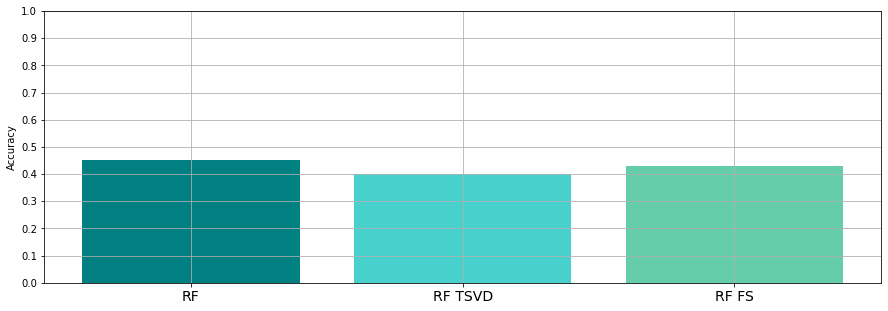

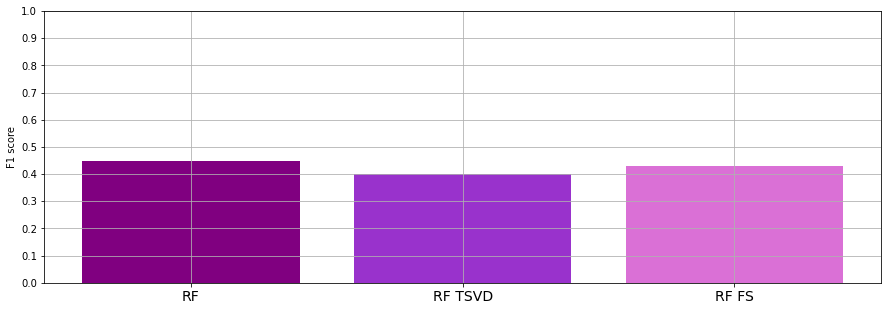

In [243]:
plot_glob_accuracy(['RF', 'RF TSVD', 'RF FS'], list_acc_adb.values())
plot_glob_f1score(['RF', 'RF TSVD', 'RF FS'], list_f1score_adb.values())

# Logistic Regression

La *Regressione Logistica* è una modello di classificazione che utilizza un approccio discriminativo.

A differenza della regressione lineare che restituisce valori numerici continui, la regressione logistica trasforma il proprio output utilizzando la funzione sigmoide o softmax per definire una distribuzione di probabilità per ogni classe.

La regressione logistica, è una GLM derivata dall'ipotesi che il valore da predire *y* seguiva una distribuzione Bernoulliana. In questi modello la probabilità condizionata di appartenenza ad una classe è stimata dalla funzione sigmoide applicata a una combinazione lineare delle features.

In formula

$$ P(\frac{C_1}{x}) ={\sigma(w^T\bar{x})}= {\frac {1} {1+e^{-w^T\bar{x}}} } $$

Per questo modello, il tuning viene eseguito sui parametri *solver*, ossia l'algoritmo che viene utilizzato per ottimizzare il problema e sul parametro *C* di regolarizzazione, che assegna una regolarizzazione più marcata a valori più piccoli.

I *solver* che abbiamo considerato sono :
1. gli algoritmi di *sag* e *saga* che sono più veloci per set di dati di grandi dimensioni
2. gli algoritmi di *sag*, *saga* e *lbfs* che gestiscono la loss multinomiale.


In [246]:
list_acc_lr = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

list_f1score_lr = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

In [ ]:
params =  { "solver":[ 'lbfgs','sag', 'saga'],
            "C": [0.1,0.5,1,10,50,100]
        }
lrc = RandomizedSearchCV(LogisticRegression(class_weight='balanced'), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
lrc.fit(X_train_scaled,y_train)

best parameters: {'solver': 'lbfgs', 'C': 100}
best score:      0.96716 (+/-0.00264)


,param_solver,param_C,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
4,lbfgs,100,0.967158,0.002638,1,1.000000,0.000000
8,lbfgs,50,0.966895,0.002529,2,1.000000,0.000000
6,saga,50,0.966040,0.002340,3,0.999976,0.000012
1,lbfgs,10,0.965888,0.002371,4,0.999958,0.000030
5,sag,10,0.965677,0.003130,5,0.999958,0.000030
7,saga,10,0.965525,0.002910,6,0.999944,0.000033
2,saga,100,0.965053,0.002599,7,0.999976,0.000012
9,saga,1,0.962167,0.002436,8,0.997080,0.000131
0,sag,0.5,0.958453,0.002123,9,0.993231,0.000241
3,saga,0.5,0.958330,0.002045,10,0.993200,0.000232


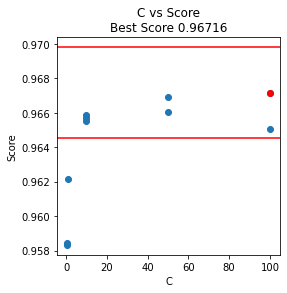

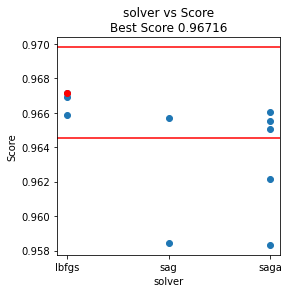

In [ ]:
RandomizedSearch_table_plot(lrc, param_list=["C", "solver"],negative=False)

In [430]:
y_pred_lrc = lrc.predict(X_test_scaled)
show_results(y_test, y_pred_lrc)
list_acc_lr['simple'] = accuracy_score(y_test, y_pred_lrc)
list_f1score_lr['simple'] = f1_score(y_test, y_pred_lrc, average='weighted')

Accuracy:  0.9740437158469946
Avg Precision 0.9741772233417145
Avg Recall 0.9740437158469946
Avg F1-score 0.9739875382656256


## Logistic Regression con Truncated Svd


In [ ]:
params =  { "solver":[ 'lbfgs','sag', 'saga'],
            "C": [0.1,0.5,1,10,50,100]
        }
lrc_tsvd = RandomizedSearchCV(LogisticRegression(class_weight='balanced'), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
lrc_tsvd.fit(X_train_tsvd,y_train)

best parameters: {'solver': 'saga', 'C': 10}
best score:      0.95733 (+/-0.00235)


,param_solver,param_C,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,saga,10,0.957329,0.002349,1,0.999215,0.000082
6,saga,50,0.956727,0.002999,2,0.999680,0.000022
2,lbfgs,10,0.956255,0.002328,3,0.999332,0.000053
7,lbfgs,100,0.955048,0.002988,4,0.999976,0.000012
5,saga,1,0.954554,0.003410,5,0.990896,0.000316
8,sag,1,0.954554,0.003410,5,0.990896,0.000316
0,sag,100,0.951948,0.003459,7,0.999905,0.000046
1,saga,0.5,0.950058,0.003679,8,0.984015,0.000151
9,lbfgs,0.5,0.950058,0.003679,8,0.984015,0.000151
4,saga,0.1,0.923154,0.004697,10,0.953631,0.000968


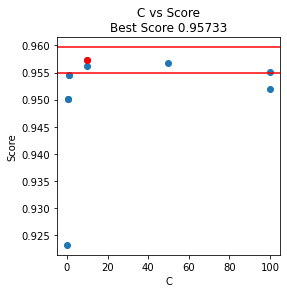

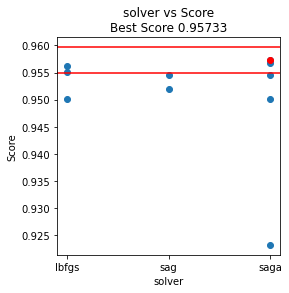

In [37]:
RandomizedSearch_table_plot(lrc_tsvd, param_list=["C", "solver"],negative=False)

In [431]:
y_pred_lrc_tsvd = lrc_tsvd.predict(X_test_tsvd)
show_results(y_test, y_pred_lrc_tsvd)
list_acc_lr['tsvd'] = accuracy_score(y_test, y_pred_lrc_tsvd)
list_f1score_lr['tsvd'] = f1_score(y_test, y_pred_lrc_tsvd, average='weighted')

Accuracy:  0.9624937903626428
Avg Precision 0.9627962509401854
Avg Recall 0.9624937903626428
Avg F1-score 0.9624985771751552


## Logistic Regression con Feature Selection

In [ ]:
params =  { "solver":[ 'lbfgs','sag', 'saga'],
            "C": [0.1,0.5,1,10,50,100]
        }
lrc_fs = RandomizedSearchCV(LogisticRegression(class_weight='balanced'), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
lrc_fs.fit(X_train_fs,y_train)

best parameters: {'solver': 'sag', 'C': 10}
best score:      0.95602 (+/-0.00350)


,param_solver,param_C,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
4,sag,10,0.956017,0.003495,1,0.999711,0.000057
7,lbfgs,100,0.955995,0.003414,2,1.000000,0.000000
2,lbfgs,50,0.955895,0.003632,3,0.999953,0.000035
9,saga,10,0.955781,0.003017,4,0.999656,0.000035
6,saga,50,0.954704,0.003856,5,0.999866,0.000056
1,lbfgs,1,0.951565,0.003466,6,0.993287,0.000236
5,sag,0.5,0.947084,0.003052,7,0.986870,0.000294
0,lbfgs,0.5,0.946978,0.003180,8,0.986729,0.000310
8,lbfgs,0.1,0.916764,0.005578,9,0.953690,0.000474
3,saga,0.1,0.916136,0.004161,10,0.953374,0.001825


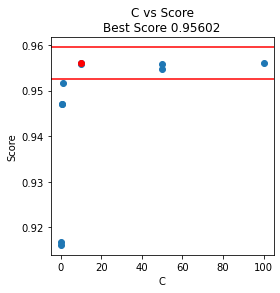

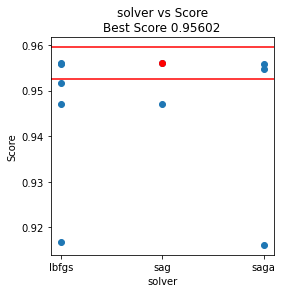

In [ ]:
RandomizedSearch_table_plot(lrc_fs, param_list=["C", "solver"],negative=False)

In [432]:
y_pred_lrc_fs = lrc_fs.predict(X_test_fs)
show_results(y_test, y_pred_lrc_fs)
list_acc_lr['fs'] = accuracy_score(y_test, y_pred_lrc_fs)
list_f1score_lr['fs'] = f1_score(y_test, y_pred_lrc_fs, average='weighted')

Accuracy:  0.9634873323397913
Avg Precision 0.9637513809300464
Avg Recall 0.9634873323397913
Avg F1-score 0.9634759012367703


## Confronto Logistic Regression

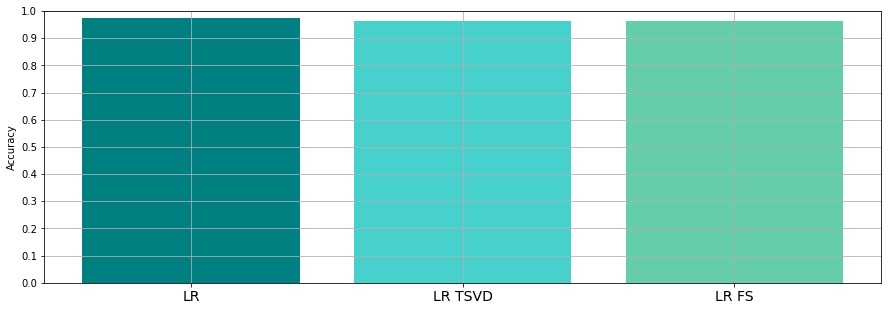

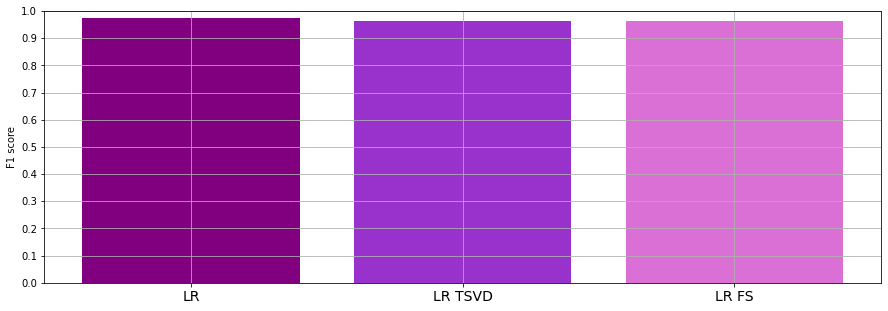

In [253]:
plot_glob_accuracy(['LR', 'LR TSVD', 'LR FS'], list_acc_lr.values())
plot_glob_f1score(['LR', 'LR TSVD', 'LR FS'], list_f1score_lr.values())

# Support Vector Machine
Le Support Vector Machines sono un modello di classificazione lineare che ci permette di definire degli iperpiani di separazione tra le classi.
L'idea di fondo delle SVMs infatti è quella di cercare l'iperpiano *"migliore"* che separa le classi nello spazio delle features rispetto ad una misura di separazione.

Il kernel scelto è quello ***lineare***: $k(x_i, x_j)=(x_i*x_j)$.
Questo ci ha consento di eseguire l'*hyperparameter tuning* solo sul  *termine di regolarizzazione*, ovvero ***C***.



In [254]:
list_acc_svm = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

list_f1score_svm = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

In [30]:
params=  { "C": [0.1,0.5,1,10,50,100] }
svc = RandomizedSearchCV(LinearSVC(class_weight='balanced'), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
svc.fit(X_train_scaled,y_train) 

/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


best parameters: {'C': 0.1}
best score:      0.96736 (+/-0.00154)


,param_C,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.1,0.967360,0.001543,1,0.997359,0.000172
1,0.5,0.967082,0.001832,2,0.999907,0.000038
2,1,0.966099,0.001988,3,0.999970,0.000026
3,10,0.963220,0.001869,4,1.000000,0.000000
5,100,0.962285,0.002125,5,1.000000,0.000000
4,50,0.962268,0.002284,6,1.000000,0.000000


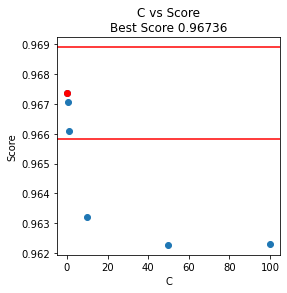

In [31]:
RandomizedSearch_table_plot(svc, param_list=["C"],negative=False)

In [32]:
y_pred_svc = svc.predict(X_test_scaled)
show_results(y_test, y_pred_svc)
list_acc_svm['simple'] = accuracy_score(y_test, y_pred_svc)
list_f1score_svm['simple'] = f1_score(y_test, y_pred_svc, average='weighted')

Accuracy:  0.9743541977148534
Avg Precision 0.9746239218003083
Avg Recall 0.9743541977148534
Avg F1-score 0.9742498244674618


## Support Vector Machine con TruncatedSVD

In [90]:
params=  { "C": [0.1,0.5,1,10,50,100] }
svc_tsvd = RandomizedSearchCV(LinearSVC(class_weight='balanced'), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
svc_tsvd.fit(X_train_tsvd,y_train) 

/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-pack

RandomizedSearchCV(cv=5, estimator=LinearSVC(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'C': [0.1, 0.5, 1, 10, 50, 100]},
                   return_train_score=True, scoring='f1_macro')

best parameters: {'C': 0.1}
best score:      0.95578 (+/-0.00258)


,param_C,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.1,0.955782,0.002585,1,0.989524,0.000586
1,0.5,0.952097,0.003985,2,0.996927,0.000088
2,1,0.948555,0.004010,3,0.998121,0.000125
3,10,0.930568,0.003566,4,0.999846,0.000060
4,50,0.922924,0.002227,5,0.999994,0.000012
5,100,0.920632,0.002330,6,0.999997,0.000007


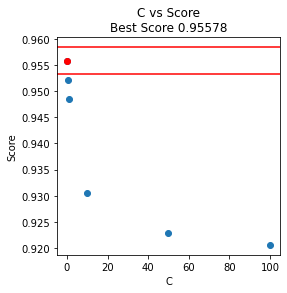

In [91]:
RandomizedSearch_table_plot(svc_tsvd, param_list=["C"],negative=False)

In [92]:
y_pred_svc_tsvd = svc_tsvd.predict(X_test_tsvd)
show_results(y_test, y_pred_svc_tsvd)
list_acc_svm['tsvd'] = accuracy_score(y_test, y_pred_svc_tsvd)
list_f1score_svm['tsvd'] = f1_score(y_test, y_pred_svc_tsvd, average='weighted')

Accuracy:  0.9626800794833582
Avg Precision 0.9631593647139994
Avg Recall 0.9626800794833582
Avg F1-score 0.9625437156424466


## Support Vector Machine con Features Selection

In [25]:
params=  { "C": [0.1,0.5,1,10,50,100] }
svc_fs = RandomizedSearchCV(LinearSVC(class_weight='balanced'), n_jobs=-1, param_distributions=params, cv=5, scoring='f1_macro',return_train_score=True)
svc_fs.fit(X_train_fs,y_train) 

/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/myenv/lib/python3.9/site-pack

best parameters: {'C': 0.1}
best score:      0.95535 (+/-0.00229)


,param_C,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.1,0.955352,0.002289,1,0.992802,0.000296
1,0.5,0.954395,0.002953,2,0.998771,0.000106
2,1,0.951330,0.003150,3,0.999452,0.000087
3,10,0.940341,0.003068,4,0.999977,0.000028
4,50,0.936207,0.003400,5,1.000000,0.000000
5,100,0.934929,0.003646,6,1.000000,0.000000


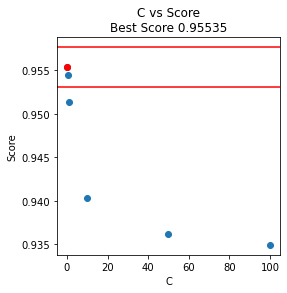

In [26]:
RandomizedSearch_table_plot(svc_fs, param_list=["C"],negative=False)

In [28]:
y_pred_svc_fs = svc_fs.predict(X_test_fs)
show_results(y_test, y_pred_svc_fs)
list_acc_svm['fs'] = accuracy_score(y_test, y_pred_svc_fs)
list_f1score_svm['fs'] = f1_score(y_test, y_pred_svc_fs, average='weighted')

Accuracy:  0.9636115250869349
Avg Precision 0.9639677238268058
Avg Recall 0.9636115250869349
Avg F1-score 0.963480779500028


## Confronto Support Vector Machine


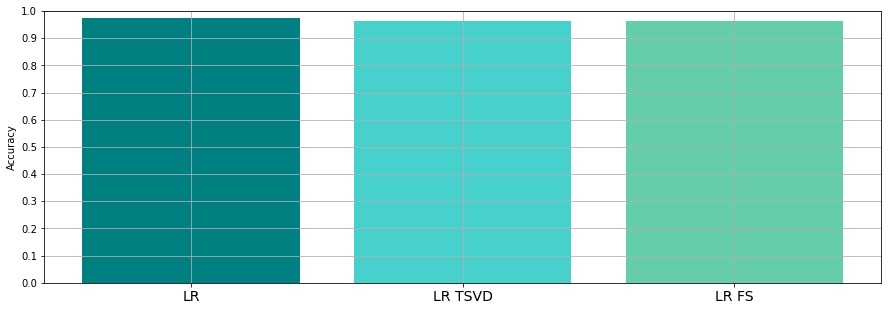

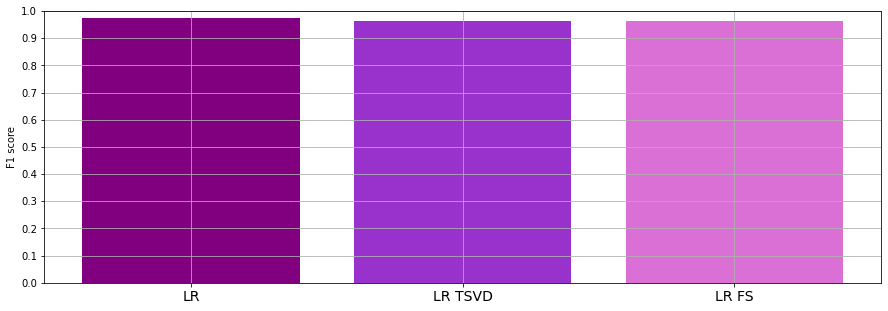

In [259]:
plot_glob_accuracy(['LR', 'LR TSVD', 'LR FS'], list_acc_svm.values())
plot_glob_f1score(['LR', 'LR TSVD', 'LR FS'], list_f1score_svm.values())

# K-Nearest Neighbors
K-nearest Neighbors è un modello non parametrico usato per la classificazione probabilistica. L'idea è quella di fissare un certo K e di estendere la dimensione della regione intorno all'item x da classificare, in modo tale da includere i suoi K elementi più vicini. Per fare questo ovviamente è necessaria una metrice che ci permette di misurare la similarità tra due elementi del training set.

Infine, la classificazione viene fatta assegnando l'elemento x alla classe che compare più frequentemente tra questi K elementi.


Per questo particolare modello, abbiamo notato che sui train sets usati fino ad ora, le prestazioni calavano notevolmente. 
Questo è dovuto probabilmente allo scaler ***MAxAbsScaler()***  applicato alla matrice tf-idf. 

Di conseguenza, abbiamo deciso di usare la matrice tf-idf  *data_train_vectorized* senza applicare nessuno scaler, andando ad usare nuovamente le funzioni di feature extraction e feature selection con mutual information. 

## TruncatedSVD e Feature selection senza Scaler

In [ ]:
tsvd_prova = TruncatedSVD(n_components=data_train_vectorized.shape[1]-1, algorithm='arpack')
tsvd_prova.fit(data_train_vectorized)

In [ ]:
tsvd_var_ratios_prova = tsvd_prova.explained_variance_ratio_
best = select_n_components(tsvd_var_ratios_prova, 0.70)
best

1578

In [ ]:
# Nuovi train e test set con TruncatedSVD
best_tsvd_knn = TruncatedSVD(n_components=best,algorithm='arpack')
X_train_tsvd_knn = best_tsvd_knn.fit_transform(data_train_vectorized)
X_test_tsvd_knn = best_tsvd_knn.transform(data_test_vectorized)

In [ ]:
# Nuovi train e test set con Feature Selection
mic_knn = SelectKBest(mutual_info_classif,k=2936)
X_train_fs_knn = mic_knn.fit_transform(data_train_vectorized,y_train)
X_test_fs_knn = mic_knn.transform(data_test_vectorized)

Addestriamo ora il classificatore KNN su questi dataset:
1) data_train_vectorized
2) X_train_tsvd_knn
3) X_train_fs_knn

In [379]:
list_acc_knn = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

list_f1score_knn = {
    "simple": None,
    "tsvd": None,
    "fs": None,
}

In [ ]:
params= {"n_neighbors": [5,7,9,10,11,13,15]}

knn = RandomizedSearchCV( KNeighborsClassifier(), param_distributions=params, n_jobs = -1,cv=5, scoring='f1_macro',return_train_score=True)
knn.fit(data_train_vectorized, y_train)

best parameters: {'n_neighbors': 5}
best score:      0.82489 (+/-0.00353)


,param_n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,5,0.824893,0.003527,1,0.895255,0.001094
1,7,0.818011,0.003520,2,0.874248,0.002346
2,9,0.811014,0.002766,3,0.860798,0.002004
3,10,0.807720,0.001508,4,0.854162,0.002429
4,11,0.804309,0.002826,5,0.848577,0.002015
5,13,0.799388,0.002213,6,0.838937,0.002444
6,15,0.792115,0.003425,7,0.831310,0.002872


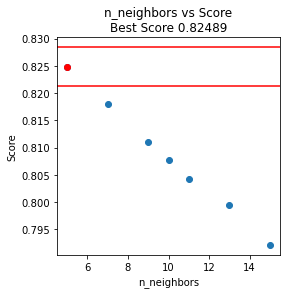

In [378]:
RandomizedSearch_table_plot(knn, param_list=["n_neighbors"],negative=False)

In [384]:
y_pred_knn = knn.predict(data_test_vectorized)
show_results(y_test, y_pred_knn)
list_acc_knn['simple'] = accuracy_score(y_test, y_pred_knn)
list_f1score_knn['simple'] = f1_score(y_test, y_pred_knn, average='weighted')

Accuracy:  0.8668653750620964
Avg Precision 0.8743093172268537
Avg Recall 0.8668653750620964
Avg F1-score 0.8659495864317871


## K-Nearest Neighbors con TruncatedSVD


In [ ]:
params= {"n_neighbors": [5,10,15,20,25,30]}

knn_tsvd = RandomizedSearchCV( KNeighborsClassifier(), param_distributions=params, n_jobs = -1,cv=5, scoring='f1_macro',return_train_score=True)
knn_tsvd.fit(X_train_tsvd_knn, y_train)

best parameters: {'n_neighbors': 25}
best score:      0.80770 (+/-0.00259)


,param_n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
4,25,0.807701,0.002593,1,0.847207,0.004161
3,20,0.807055,0.003478,2,0.853552,0.003866
5,30,0.806135,0.003322,3,0.841684,0.003174
2,15,0.803578,0.005584,4,0.860738,0.005876
1,10,0.798834,0.007187,5,0.870152,0.005302
0,5,0.786945,0.009606,6,0.894424,0.005460


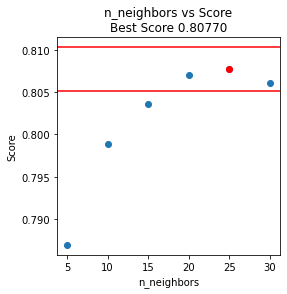

In [390]:
RandomizedSearch_table_plot(knn_tsvd, param_list=["n_neighbors"],negative=False)

In [391]:
y_pred_knn_tsvd = knn_tsvd.predict(X_test_tsvd_knn)
show_results(y_test, y_pred_knn_tsvd)
list_acc_knn['tsvd'] = accuracy_score(y_test, y_pred_knn_tsvd)
list_f1score_knn['tsvd'] = f1_score(y_test, y_pred_knn_tsvd, average='weighted')

Accuracy:  0.841157476403378
Avg Precision 0.8709887820796322
Avg Recall 0.841157476403378
Avg F1-score 0.8472965101205403


## K-Nearest Neighbors con Feature Selection

In [ ]:
params= {"n_neighbors": [5,7,9,10,11,13,15]}

knn_fs = RandomizedSearchCV( KNeighborsClassifier(), param_distributions=params, n_jobs = -1,cv=5, scoring='f1_macro',return_train_score=True)
knn_fs.fit(X_train_fs_knn, y_train)

best parameters: {'n_neighbors': 5}
best score:      0.35401 (+/-0.02052)


,param_n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,5,0.354014,0.020521,1,1.0,0.0
1,7,0.316458,0.028213,2,1.0,0.0
2,9,0.291867,0.028623,3,1.0,0.0
3,11,0.278893,0.030721,4,1.0,0.0
4,13,0.273333,0.033822,5,1.0,0.0
5,15,0.266903,0.029292,6,1.0,0.0


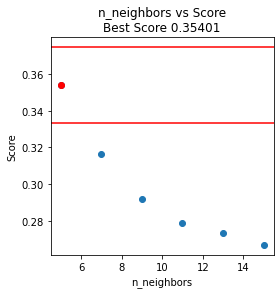

In [393]:
RandomizedSearch_table_plot(knn_fs, param_list=["n_neighbors"],negative=False)

In [394]:
y_pred_knn_fs = knn_fs.predict(X_test_fs_knn)
show_results(y_test, y_pred_knn_fs)
list_acc_knn['fs'] = accuracy_score(y_test, y_pred_knn_fs)
list_f1score_knn['fs'] = f1_score(y_test, y_pred_knn_fs, average='weighted')

Accuracy:  0.3947466467958271
Avg Precision 0.8657539563730061
Avg Recall 0.3947466467958271
Avg F1-score 0.46058952138664255


## Confronto
Come possiamo notare, il training set con features selection ha delle prestazioni nettamente inferiori rispetto agli altri due, in quanto riduciamo a metà il numero di features. Questo evidentemente ha portato alla perdita di troppe informazioni per questo particolare modello, che sfrutta il concetto di *vicinanza* tra items.

Un altro fattore che ha influito è sicuramente lo sbilanciamento delle classi.

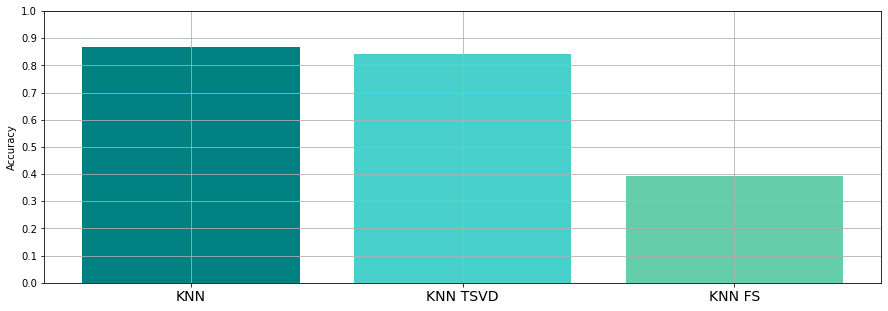

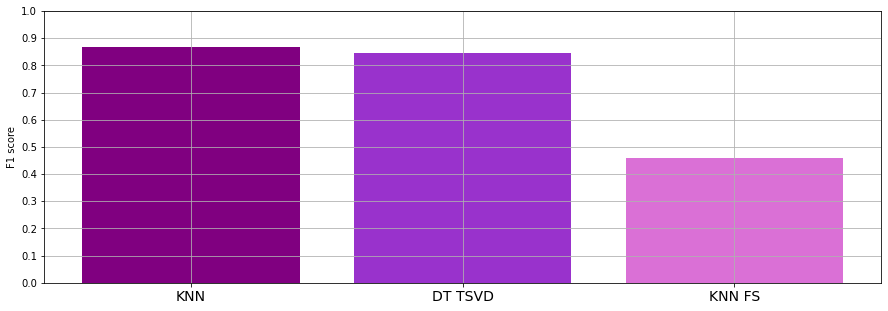

In [395]:
plot_glob_accuracy(['KNN', 'KNN TSVD', 'KNN FS'], list_acc_knn.values())
plot_glob_f1score(['KNN', 'DT TSVD', 'KNN FS'], list_f1score_knn.values())

# Conclusioni
Per affrontare il forte sbilanciamento delle classi, nella valutazione dei vari modelli, abbiamo applicato diverse metriche di valutazione dei risultati: Accuracy, Precision, Recall, F1-score.

Di seguito abbiamo costruito un grafico riassuntivo dei risultati ottenuti in termini di accuracy e f1-score, confrontando queste misure rispetto ai diversi training sets.

Dai risultati ottenuti, la regressione logistica e le support vector machines sono i modelli che hanno avuto le performance migliori.

## Confronto Accuracy

<Figure size 432x288 with 0 Axes>

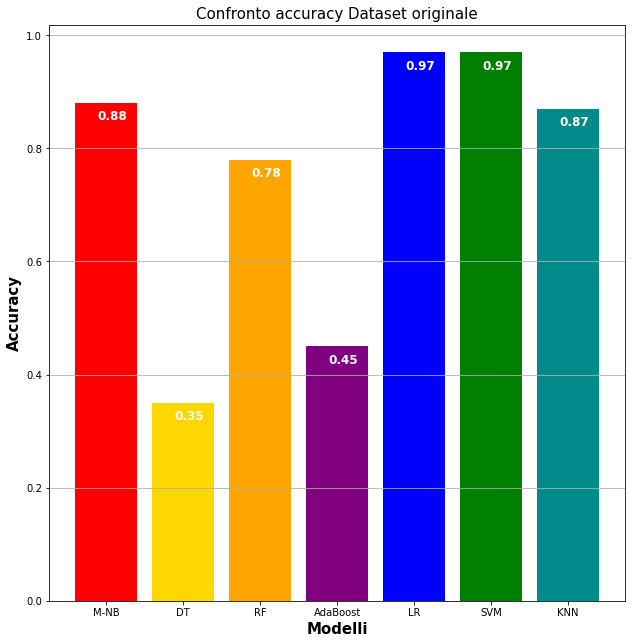

<Figure size 432x288 with 0 Axes>

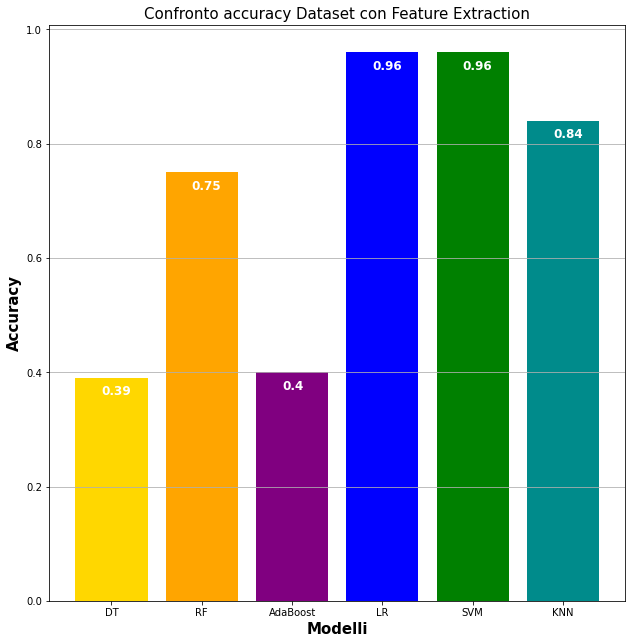

<Figure size 432x288 with 0 Axes>

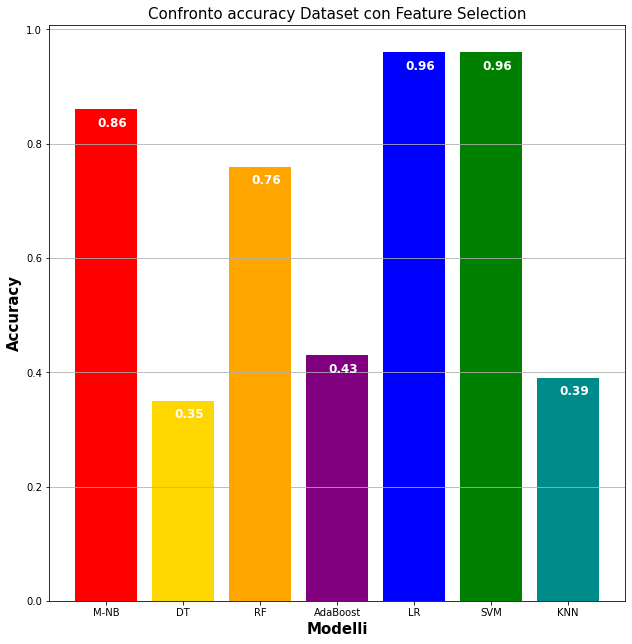

In [398]:
# Confronto Dataset originale
fig = plt.figure()
fig, ax = plt.subplots(figsize=(4, 4))
ax = fig.add_axes([0,0,2,2])
model_names = ["M-NB", "DT","RF", "AdaBoost", "LR", "SVM","KNN"]
model_scores = [0.88, 0.35, 0.78, 0.45, 0.97, 0.97, 0.87]
color = ["red","gold", "orange", "purple", "blue", "green", "darkcyan"]
ax.bar(model_names, model_scores, color=color)
ax.grid(axis='y')
plt.title("Confronto accuracy Dataset originale", fontsize=15)
plt.xlabel("Modelli", fontsize=15, fontweight="bold")
plt.ylabel("Accuracy", fontsize=15, fontweight="bold")
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)  
for i in range(len(model_names)):
    plt.text(x = i-0.11, y = model_scores[i]-0.03, s = str(model_scores[i]), color="white", size = 12, fontweight="bold")
plt.show()

#Confronto TruncatedSVD
fig = plt.figure()
fig, ax = plt.subplots(figsize=(4, 4))
ax = fig.add_axes([0,0,2,2])
model_names = [ "DT","RF", "AdaBoost", "LR", "SVM","KNN"]
model_scores = [ 0.39, 0.75, 0.40, 0.96, 0.96, 0.84]
color = ["gold", "orange", "purple", "blue", "green", "darkcyan"]
ax.bar(model_names, model_scores, color=color)
ax.grid(axis='y')
plt.title("Confronto accuracy Dataset con Feature Extraction", fontsize=15)
plt.xlabel("Modelli", fontsize=15, fontweight="bold")
plt.ylabel("Accuracy", fontsize=15, fontweight="bold")
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)  
for i in range(len(model_names)):
    plt.text(x = i-0.11, y = model_scores[i]-0.03, s = str(model_scores[i]), color="white", size = 12, fontweight="bold")
plt.show()


#Confronto Feature Selection
fig = plt.figure()
fig, ax = plt.subplots(figsize=(4, 4))
ax = fig.add_axes([0,0,2,2])
model_names = ["M-NB", "DT","RF", "AdaBoost", "LR", "SVM","KNN"]
model_scores = [0.86, 0.35, 0.76, 0.43, 0.96, 0.96, 0.39]
color = ["red","gold", "orange", "purple", "blue", "green", "darkcyan"]
ax.bar(model_names, model_scores, color=color)
ax.grid(axis='y')
plt.title("Confronto accuracy Dataset con Feature Selection", fontsize=15)
plt.xlabel("Modelli", fontsize=15, fontweight="bold")
plt.ylabel("Accuracy", fontsize=15, fontweight="bold")
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)  
for i in range(len(model_names)):
    plt.text(x = i-0.11, y = model_scores[i]-0.03, s = str(model_scores[i]), color="white", size = 12, fontweight="bold")
plt.show()

## Confronto F1-score

<table align="center">
<tbody>
<tr>
<th class="tg-s6z2" style="text-align: center;" colspan="4"><span style="font-weight: bold;">F1-score</span></th>
</tr>
<tr>
    <td></td>
    <td><span style="font-weight: bold;">Dataset originale</span></td>
    <td><span style="font-weight: bold;">TruncatedSVD</span></td>
    <td><span style="font-weight: bold;">Features Selection</span></td>
  </tr>
  <tr>
    <td><span style="font-weight: bold;">Multinomial NB</span></td>
    <td>88%</td>
    <td>✘</td>
    <td>86%</td>
  </tr>
  <tr>
    <td><span style="font-weight: bold;">Decision Tree</span></td>
    <td>37%</td>
    <td>40%</td>
    <td>38%</td>
  </tr>
  <tr>
    <td><span style="font-weight: bold;">Random Forest</span></td>
    <td>78%</td>
    <td>73%</td>
    <td>76%</td>
  </tr>
  <tr>
    <td><span style="font-weight: bold;">Adaboost</span></td>
    <td>45%</td>
    <td>40%</td>
    <td>43%</td>
  </tr>
  <tr>
    <td><span style="font-weight: bold;">Logistic Regression</span></td>
    <td>97%</td>
    <td>96%</td>
    <td>96%</td>
  </tr>
  <tr>
    <td><span style="font-weight: bold;">Support Vector Machine</span></td>
    <td>97%</td>
    <td>96%</td>
    <td>96%</td>
  </tr>
  <tr>
    <td><span style="font-weight: bold;">K-NN</span></td>
    <td>86%</td>
    <td>85%</td>
    <td>46%</td>
  </tr>
</table>